# Modeling and Predicting Student Dropout in Yiya Air Science Courses

In this project, our first aim to identify the points in the Yiya Air Science courses 2 and 3 where students dropout. There are different ways extents and ways to measure drop out. For example, dropout metrics we try to preedict can be defined as a:
1. **Usage Gap**, where the time since the students last response is more than a certain amount of days e.g (e.g more than 7 days since last response). This can be seen as students being "on track" or "behind". We'll know if a user has performed a usage gap if the time between their most recent and last response to the system is more than N days. A reasonable value for N would be 7 days because the course modules are delivered weekly.
    - Alternatively, a usage gap can be defined as a user not sending any message to the system within a certain week.
    - Usage Gap = 1, if R2 - R1 > 7 days 
    - We can code a user as behind if they have a usage gap and AND the user_tasks < tasks_released, where R2= time of response 2, R1 = time of response 1
    - A response is any logged entry to the response table.
    
    `if (date_of_response_2 - date_of_response_1) > 7_days AND user_completed_tasks < tasks_released:`
        
        usage_gap == 1

2. **Total Question Stop**, where a student stops submitting scored_problems in the course before completing all tasks [(Borella, et al., 2019)](https://mitili.mit.edu/sites/default/files/project-documents/a24-Borrella_Caballero_Ponce_2019.pdf)
    - Total Question Stop = 1, if R2 - R1 > 7 days AND user_scored_problems < 50%_of_scored_problems_released, where R2= time of response 2, R1 = time of response 1
    - ❗️**Input Needed:** Is there an overall schedule of when tasks are accessible to users?
4. **Total Completion Stop**, where a student stops completing tasks (lesson modules and tests)
    - Tasks can be lessons, tests, or surveys
    
5. **Opt out** - student voluntarily unenrolls from the course without achieving a certificate [(Tinto, 1975)](https://www-tandfonline-com.cmu.idm.oclc.org/doi/full/10.1080/01587919.2017.1369006#)

Our second aim is to measure and visualize the rate of each of these dropout metrics among students over time and each course step. We can do so by diving the total occurances by the number of studnets. (Counts of students meeting dropout criteria / total number of students).

Our third aim is to identify features (variables) that are predictive of dropout with a classification model. Prior research suggests a need to refine success and dropout metrics [(Kohler, 2019)](https://www-tandfonline-com.cmu.idm.oclc.org/doi/full/10.1080/01587919.2017.1369006). It is uncertain if we have all of the following features in our data. However, we can try features grounded in previous theories, empircal results, and our best judgement on what makes sense for the context of the learning environment and the student population.  but some features that we may be able to use in our model and evaluate for predictive power include: 
- Student's date of first submission of a problem [(Liyanagunawardena, 2014)](https://centaur.reading.ac.uk/36002/)
- Student Intentions [(Liyanagunawardena, 2014)](https://centaur.reading.ac.uk/36002/)
    - Unsure
    - Browse Course
    - Audit
    - Complete
- Participation type [(Kohler, 2013)](https://er.educause.edu/articles/2013/6/retention-and-intention-in-massive-open-online-courses-in-depth)
    - Browser
    - Passive Participant 
    - Active Participant
    - Community Contributor
We can try to align participant types with [Yiya User Definitions](https://docs.google.com/document/d/1KNgPFdRSBniQouaKIQQPuI-DlAL-2xs70t4rpps5Qq4/edit)
- Completion Behavior
    - Number of lesson modules (tasks) completed
    - Number of lesson questions completed
    - Number of questions answered correctly
    - Number of tests they've completed 
    - Whether they are a returning learner - There should be a record for each Registration, Previously registered key in response as well. Data team will have to get back to us on how to best query the data to get an accurate user.
- Time on Task metric
    - Minutes spent on a task / Average time of session - We can use the telcomsession table and the created and duration feature. There can be telecom issues so users can get kicked out before completing the script. We'll have to consider this. We may have to compare with the tasks table.
- Review Behaviors 
    - Number of Times Revising Previous Lesson
- Effect of payment
    - Payment Status (Scholarship or Self Paid with mobile money) 
    - payment survey question - Required question in the response table. Shariffa will share the key. 
    
Note about "effect of payment": The date at which non-paid users lost access to course 3 was [*To be confirmed by yiya team, date was potentially nov 4th*]
Some required questions have required in their key?

Our final aim and outcome for prediction is completion. Yiya as different levels of completion:
- The *standard completion* for Yiya is that a user:
    - Attempted at least 60% of lesson questions
    - Attempted at least 40% of tests
- The *certificate of completion criteria* is:
    - Attempted at least 60% of lesson questions
    - Attempted at least 40% of test questions

# Exploring the Database

Yiya has a large database containing course content, user information, and interactions. The data spans multiple courses. The Entity Relationship Diagram below shows the relationships between the tables and the fields each table contains. The goal for this section of the report is to document how data is represented and collected to provide context for the future all analysis. 

We have the following tables:
- `content` - which describes the text or audio content users see or hear on their phones
- `outbound` - which tracks cellular data being from the system to users
- `inbound` - which tracks cellular data being to the system from users
- `response` - which describes the values users select from menus, surveys, lessons, tests, and other activities
- `user` - which describes the status of each user
- `task` - which records completions of tasks i.e completion of surveys, lessons, tests, etc.
- `registration` - which records each record of a user registration for a course
- `course` - which records each instance of a course run
- `channel`- **TECH TEAM INPUT NEEDED:** *the purpose of this table is unclear to the author of this notebook at time of writing*
- `telecommession` - which describes each session started on USSD by users.

❗️ Additional notes are needed on conditions under which each record is generated. 

**Recommendations for Future Tables and Fields**
- Survey table - Adding a table for surveys would help with the duplicate response problem in the response table. I recommend logging survey responses after the last survey question has been completed to ensure accurate survey data.
- Task Table Fields
    - time_taken - record the time between a user starting a tasks and completing a task after the task has been completed
    - score - record the score for lessons or tests after they have been completed. non scored tasks can be left empty.

Now that we have had an overview of the tables, we can quickly look at each table to identify data that can be used to model student dropout behaviors.

![Image of ERD][1]

[1]: Documentation/ERD_2022-10-25.png

## Content Table
First, we'll examine the content table.

In [6]:
import pandas as pd

pd.set_option('display.max_columns', 1000) #show columns in scrollable table
pd.set_option('display.max_rows', 500)
pd.set_option("max_colwidth", None) #don't truncate data in columns.
pd.set_option('display.max_columns', 1000) #show columns in scrollable table
pd.set_option('display.max_rows', 500)
pd.set_option("max_colwidth", None) #don't truncate data in columns.

#read file from data folder, return file
def read_data(file_name, folder="/Users/ddbutler/Desktop/Repos/Yiya-Solutions-Analysis/yiya-completion-analysis/course3_data_v2_pickle/"):
    #combine foler and file name to get the full path
    df = pd.read_pickle(folder + file_name)
    return df

content_df = read_data(file_name="content.pkl")
content_df.sample(3, random_state=5) #See sample of data

,created,updated,script,section,version,kind,content,correct_value
id,,,,,,,,
22962,2022-09-29 18:42:11,2022-09-29 18:42:11,content/overview-yiya-airscience-course-2021-overview,.,zE2zM35idcz-xF38YMsAWQ,text,"Intro: What is STEM?\n1: Identify the problem\n2: Investigate\n3: Brainstorm\n4: Plan\n5: Create\n6: Test\n7: Improve\n8: Launch\n0. moto sandra, Continue...",None
38423,2022-10-18 10:38:10,2022-10-18 10:38:10,content/airscience-2022a/course/step-3-brainstorm/step-3-lesson-1/go-to-questions,q1-which-technology-are-we-going-to-create-in-this-course,p1i5dVVWfi1ZAPsvqpZDYg,text,That's not it OLIK JOSEPH... Try again.\n1/4: Which technology are we going to create in this course?\n1. Pedal powered washing machine\n2. An electric washing machine,Pedal powered washing machine
30187,2022-10-07 10:27:15,2022-10-07 10:27:15,content/airscience-2022a/course/step-1-identify/step-1-lesson-4/go-to-questions,what-is-6-out-of-10-as-a-percentage,cBR0we9JPtr2JmCRlp2ELw,text,Thank you P for answering lesson questions!,None


Based on this sample of the data we'll assume the following descriptions of the most relevant fields: 
- `created`: The created field is most likely the time content was served to the user
- `script` : The script field seems to be the activity being presented to a user.  *TODO❗️* There's a pattern that need to be described e,g
    - `content/airscience-2022a/course/step-3-brainstorm/step-3-lesson-1/go-to-questions`
    - `content/airscience-2022a/course/step-1-identify/step-1-lesson-4/go-to-questions`
    - `content/overview-yiya-airscience-course-2021-overview`
- `section`: The section field seems to describe the specific question or action within a script activity. 
- `version`: **Tech Team Input Needed**
- `kind`: The kind field suggests there are different types of content. *TODO❗️* We will look at the types of content later.
- `content`: The content field seems to be what the user actually sees or hears. 
- `correct_value`: The correct values field seems to mark the correct value for lesson and tests.

Now that we have an understanding of the field descriptions, we can look at the contents of the content data table in bit more more detail.


In [7]:
#content_df.describe(datetime_is_numeric=True, include="all")
#Input: a dataframe
#Output: dataframe describing data
#Description: generates summary of information about dataframe
def explore_data(df):
    """
    #content_df.describe(datetime_is_numeric=True, include="all")
    #Input: a dataframe
    #Output: dataframe describing data
    #Description: generates summary of information about dataframe
    """

    #Set display options for easier viewing
    pd.set_option('display.max_columns', 1000) #show columns in scrollable table
    pd.set_option('display.max_rows', 500)
    pd.set_option("max_colwidth", None) #don't truncate data in columns.

    #See information on fields
    print("Information on Fields")
    print("----------------------")
    df.info()

    #See info on missing data
    print("\nPercentage of Missing Values")
    print("----------------------")
    print((df.isna().sum() / df.shape[0]) * 100)

    return df.describe(datetime_is_numeric=True, include="all")

#Check kinds of content
print("Kinds of Content: ",content_df["kind"].unique())
print("---")
#Print data summary
explore_data(content_df)

Kinds of Content:  ['text' 'audio']
---
Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78532 entries, 1 to 78562
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   created        78532 non-null  datetime64[ns]
 1   updated        78532 non-null  datetime64[ns]
 2   script         78531 non-null  object        
 3   section        78531 non-null  object        
 4   version        78461 non-null  object        
 5   kind           78532 non-null  object        
 6   content        78532 non-null  object        
 7   correct_value  73517 non-null  object        
dtypes: datetime64[ns](2), object(6)
memory usage: 5.4+ MB

Percentage of Missing Values
----------------------
created          0.000000
updated          0.000000
script           0.001273
section          0.001273
version          0.090409
kind             0.000000
content          0.000000
cor

,created,updated,script,section,version,kind,content,correct_value
count,78532,78532,78531,78531,78461,78532,78532,73517
unique,NaN,NaN,326,474,1067,2,62808,104
top,NaN,NaN,content/course-menu,.,cBR0we9JPtr2JmCRlp2ELw,text,Welcome to Yiya AirScience!\n1. On the Radio today\n2. Course Overview\n3. Revise previous content\n4. What to do next\n5. On the Radio today\n6. Course Overview\n7. What to do next Previous Lessons\n8. On the Radio today\n9. Course Overview\n10. Revise previous c,None
freq,NaN,NaN,6091,31981,6007,78398,632,52070
mean,2022-10-08 08:24:13.047101696,2022-10-08 08:24:13.047114496,NaN,NaN,NaN,NaN,NaN,NaN
min,2021-06-17 19:10:00,2021-06-17 19:10:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,2022-09-26 14:11:26.750000128,2022-09-26 14:11:26.750000128,NaN,NaN,NaN,NaN,NaN,NaN
50%,2022-10-19 10:09:05.500000,2022-10-19 10:09:05.500000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2022-11-12 21:29:16.249999872,2022-11-12 21:29:16.249999872,NaN,NaN,NaN,NaN,NaN,NaN
max,2022-12-28 13:20:07,2022-12-28 13:20:07,NaN,NaN,NaN,NaN,NaN,NaN


Look at the description of the data above, 78,532 instances of users receiving content. The data is fairly complete. The only column with significant missing values is the `correct_value` column, which suggests that about 6% of content served is non lesson or test. The dates range from `2021-06-17` to `2022-10-19`.

There are 326 unique scripts (activities) between the first to most recent course.  We have 2 kinds of content: `text` and `audio`.  The most recent content suggests the course menu, which serves as the entry point for users.

### Analysis Questions

Understanding the course table, allows us to ask some questions about dropout.
- Do students who complete the course listen to audio content at a higher rate?
- What content is communicated via audio?

In [8]:
audio_content = content_df.query("kind == 'audio'")
print("\nAudio Content Summary")
print("Unique Scripts", audio_content["script"].unique())
print("\nUnique Sections\n", audio_content["section"].unique())
audio_content.sample(3, random_state=5)



Audio Content Summary
Unique Scripts ['content/for-testers' 'content/for-registered' 'content/active_users'
 'content/airscience-2022a/schedules/for-testers'
 'content/airscience-2022b/schedules/for-testers'
 'content/airscience-2022a/schedules/for-registered'
 'content/airscience-2022b/schedules/for-registered']

Unique Sections
 ['Friday' 'Friday, June 25' 'Monday, June 28' 'Wednesday, June 30'
 'July 1' 'Wednesday July 07, 2021' 'Thursday July 08, 2021'
 'Friday July 09, 2021' 'Sunday July 11, 2021' 'Monday July 12, 2021'
 'Monday July 13, 2021' 'Sunday July 18, 2021' 'Sunday July 18'
 'Saturday July 24, 2021' 'Sunday July 25, 2021' 'Sunday July 25'
 'Thursday July 29' 'Sunday August 1, 2021' 'Monday August 09, 2021'
 'Tuesday August 10, 2021' 'Tuesday August 10' 'Sunday August 15,2021'
 'Friday  August 20, 2021' 'Friday August 27, 2021'
 'Friday September 17, 2021' 'Sunday, September 19'
 'Friday October 1, 2021' 'Sunday, October 3' 'Monday, October 4'
 'Tuesday, October 5' 'Thurs

,created,updated,script,section,version,kind,content,correct_value
id,,,,,,,,
1141,2021-07-24 07:00:01,2021-07-24 07:00:01,content/for-testers,"Saturday July 24, 2021",o-YlVlmqLRwtXmEmthIjIg,audio,../.gitbook/assets/step_2_robocall.mp3,NaN
1483,2021-08-10 13:00:07,2021-08-10 13:00:07,content/for-registered,Tuesday August 10,NaN,audio,../.gitbook/assets/step3_brainstorm_robocall.mp3,NaN
47071,2022-10-30 13:00:04,2022-10-30 13:00:04,content/airscience-2022a/schedules/for-registered,"Sunday, October 30, 2022",cO-o8BWsu1Q-5xoPrDfeFQ,audio,../../../.gitbook/assets/Course_3_Step_5_Robocall.mp3,NaN


Looking at the sample, the `created `dates tell us that audio content is used for multiple courses and the sections are just labels for the days the content was sent out. 

#### **Do students who persist listen to audio content at a higher rate?** - 
It looks like the content table can't answer this question because there's no easy link with user_id. However, the `channel table` has fields for `user_id` and `kind`. We'll mine that data from there later. Although, the content description for audio content does have useful labels for names that suggest which part of the course the audio is for. What content is communicated via audio?
- **TODO:** Explore the channel table to investigate what kinds of content groups of learners are requesting.

#### **What content is communicated via audio?** 
Based on the `content` field, These seem to be mostly robocalls. Based on the curriculum documentation, robocalls are previews of what is coming up in the course. 
- **TODO❗️**: A Question for yiya team, what is the purpose of robocalls? When are they sent out in respect to broadcasts? Can robocalls be requested by users any time?

## Outbound Table
Now that we've explored the content table, let's look at the outbound table.


In [9]:
outbound_df = read_data("outbound.pkl")
outbound_df.sample(3, random_state=6)


,created,updated,channel_id,status,content_id,header
id,,,,,,
659838,2021-07-16 11:49:16,2021-07-16 11:49:16,27340,delivered,308,NaN
3259076,2022-09-18 17:52:28,2022-09-18 17:52:28,82142,delivered,5398,NaN
2339242,2021-10-01 10:55:07,2021-10-01 10:55:07,19165,delivered,2028,NaN


Based on the sample, we can describe the potentially important fields as follows:
- `created` = time message was sent out
- `channel_id` = foreign key linking to channel table
- `status` = whether message was delivered
- `content_id` = foreign key link to content table
-  `header` = cannot be understood from sample

The status and header field need further exploration. Outbounds are logged when studnets are contacted/ contact initiated by Yiya. 

In [10]:
unique_status = outbound_df["status"].unique()
print("Unique Status\n", unique_status)

unique_headers = outbound_df["header"].unique()
print("Unique Headers Sample\n", unique_headers[0:5])

explore_data(outbound_df)

Unique Status
 ['delivered']
Unique Headers Sample
 [nan
 'READ_MORE_SMS - content/course-spring-2021/intro-step/intro-step-lesson-3'
 'READ_MORE_SMS - content/solar-food-dryer'
 'READ_MORE_SMS - content/course-spring-2021/step-5-create/step-5-lesson-4'
 'READ_MORE_SMS - content/solar-food-dryer/create-solar-food-dryer']
Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4092930 entries, 1 to 4095388
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   created     datetime64[ns]
 1   updated     datetime64[ns]
 2   channel_id  int64         
 3   status      object        
 4   content_id  int64         
 5   header      object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 218.6+ MB

Percentage of Missing Values
----------------------
created        0.000000
updated        0.000000
channel_id     0.000000
status         0.000000
content_id     0.000000
header        99.733

,created,updated,channel_id,status,content_id,header
count,4092930,4092930,4.092930e+06,4092930,4.092930e+06,10890
unique,NaN,NaN,NaN,1,NaN,80
top,NaN,NaN,NaN,delivered,NaN,AUTO_TEST_REPORT - content/yiya-airscience-tests-2021/intro-step-test
freq,NaN,NaN,NaN,4092930,NaN,3022
mean,2021-12-09 21:19:34.527879168,2021-12-09 21:19:34.527888384,9.627785e+04,NaN,8.816809e+03,NaN
min,2021-06-17 19:10:01,2021-06-17 19:10:01,1.000000e+00,NaN,1.000000e+00,NaN
25%,2021-07-28 06:13:34,2021-07-28 06:13:34,5.192700e+04,NaN,2.610000e+02,NaN
50%,2021-09-14 17:06:51.500000,2021-09-14 17:06:51.500000,1.002750e+05,NaN,1.586000e+03,NaN
75%,2022-03-23 13:04:07,2022-03-23 13:04:07,1.310700e+05,NaN,2.319000e+03,NaN
max,2022-12-28 13:55:05,2022-12-28 13:55:05,2.314450e+05,NaN,7.856200e+04,NaN


There are `4,092,930` entries in the outbound table. The only value for the `status` field is `delivered`, which implies that failed messages are not saved to the database. Also, the `header` field seems to have null values or be a conbination of the stirng `READ_MORE_SMS -` and a `script` like `content/course-spring-2021/step-5-create/step-5-lesson-4'`. The outbound table alone seems unimportant for analysis beyond merging other tables given this interpretation.

## Inbound Table

Let's look at the inbound table. There may not be a much to leverage, but a quick look may be useful. 
Fields
- text: raw informaiton that shows the option users actually selected. It is hashed but an example is a, b, or c`. Some user personal data was included so it was hashed. David may send an updated version that only hashes personal information. 

In [11]:
inbound_df = read_data("inbound.pkl")
inbound_df.sample(3, random_state=6)

,created,updated,channel_id,prompt_id,text
id,,,,,
1371308,2021-08-27 19:03:45,2021-08-27 19:03:45,130046,1782895.0,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91b46729d73a27fb57e9
1819876,2021-10-07 16:28:49,2021-10-07 16:28:49,123928,2459926.0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b
713766,2021-07-21 18:21:25,2021-07-21 18:21:25,20538,884964.0,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b


Based on the sample above, the inbound table alone does not have anything interesting beyond the ability the link the other tables. The fields have include:
- created =
- channel_id - foreign key to link channel table
- prompt_id - foreign key to link response table

## Channel Table
**TODO:** Identify the purpose of the channel table. `channel`- **TECH TEAM INPUT NEEDED:** *the purpose of this table is unclear to the author of this notebook at time of writing*

Let's explore the channel table. There's a channel for each kind. There is an incoming channel for whatsapp for course 4. If you want to know how many ronbocalls a user did you can use channel and telecomsession will tell how long the channel was used.

In [12]:
channel_df = read_data("channel.pkl")
channel_df.sample(3, random_state=6)

,created,updated,user_id,kind,enabled,phone,state,task
id,,,,,,,,
10590,2021-06-22 03:18:12,2021-06-22 03:18:12,10267,ussd,1,256770557674,NaN,NaN
150862,2021-11-28 05:48:35,2021-11-28 05:48:35,50858,sms,1,256783223267,NaN,NaN
74687,2021-07-02 09:14:50,2021-07-02 09:14:50,23559,sms,1,256779927525,NaN,NaN


We see the following fields
- created, which is time record was created in YY-MM-DD format
- user_id, which is id of user
- kind, which describes the 
- enabled, which seems to be a true or false value. **TODO:** Investigate the un
- phone - phone number is the same as phone in user table.
- state - **TODO:** Verify the description of this field with tech team.
- task - **TODO:** Verify the description of this field with tech team.

There is a task table and a task field in this database, but tasks seems to be mostly null based on the sample. Let's explore the `task`, `state`, and `kind` fields in more detail.

In [13]:
#Input: a numpy array of unique values
#Output: a numpy array
def sample_array(the_array, size=5, seed=1):
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html#numpy.random.Generator.choice
    import numpy as np
    rng = np.random.default_rng(1) #Call default_rng (random generator) to get a new instance of a Generator with a seed
    random_sample = rng.choice(the_array, size)
    return random_sample

#Print sample of unique channel states
unique_state = channel_df["state"].unique()
state_sample = sample_array(unique_state, size=5, seed=1)
print("Unique Channel States\n", state_sample,)
print("Num of Unique: ", channel_df["state"].nunique(), "\n")

#print unique tasks 
unique_tasks = channel_df["task"].unique()
task_sample = sample_array(unique_tasks, size=5, seed=2)
print("Unique Task Sample\n", task_sample)
print("Num of Unique: ", channel_df["task"].nunique(), "\n")

explore_data(channel_df)

Unique Channel States
 ['content/course-menu/~zZIJ0NBhHOqBA7sIplCIhg'
 'content/course-spring-2021/step-2-investigate/step-2-lesson-3/take-quiz/~AqoczGE1_tT5aTIMnH4QGw'
 'content/onboarding/registration-selection/~'
 'content/onboarding/registration-by-student/~Chb8ucZ0jXyh0vqN0UHa5A/:/content/profile/gender/~uw_Zbsob-oWlDa50fo6JWw'
 'content/course-spring-2021/assessment-questions/~']
Num of Unique:  906 

Unique Task Sample
 ['content/course-spring-2021/step-6-test/step-6-lesson-1'
 'content/yiya-airscience-tests-2021/take-step-3-test'
 'content/airscience-2022a/course/tests/step-4-test'
 'content/airscience-2022a/course/step-7-improve/step-7-lesson-1'
 'content/solar-food-dryer']
Num of Unique:  113 

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 232316 entries, 1 to 235181
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   created  232316 non-null  datetime

,created,updated,user_id,kind,enabled,phone,state,task
count,232316,232316,232316.000000,232316,232316.0,2.323160e+05,38408,34827
unique,NaN,NaN,NaN,4,NaN,NaN,906,113
top,NaN,NaN,NaN,ussd,NaN,NaN,content/onboarding/~8F2BRCvsYUW7siifjAItNw,content/onboarding
freq,NaN,NaN,NaN,77161,NaN,NaN,6856,25666
mean,2021-12-12 22:17:37.065053440,2021-12-23 17:25:38.536377600,39527.478749,NaN,1.0,5.036789e+11,NaN,NaN
min,2021-06-17 15:53:28,2021-06-17 15:53:28,1.000000,NaN,1.0,7.600088e+08,NaN,NaN
25%,2021-07-02 09:13:12,2021-07-02 09:14:09,20072.000000,NaN,1.0,2.567728e+11,NaN,NaN
50%,2021-07-29 05:09:21,2021-08-19 17:58:44,39569.000000,NaN,1.0,2.567792e+11,NaN,NaN
75%,2022-09-14 14:50:36,2022-09-15 17:18:17.249999872,58809.000000,NaN,1.0,2.567861e+11,NaN,NaN
max,2022-12-28 14:07:12,2022-12-28 14:07:12,78691.000000,NaN,1.0,2.567900e+12,NaN,NaN


The `state` field has directory strings like `'content/course-spring-2021/step-2-investigate/step-2-lesson-3/take-quiz/~AqoczGE1_tT5aTIMnH4QGw'`. A significant difference is the string of characters like `~AqoczGE1_tT5aTIMnH4QGw` that follows at the end. About 83% of entries in the chanel table are missing values in the state column. 

The `task` field has endpoints for 2022 and 2021 e.g `'content/airscience-2022a/course/tests/step-4-test'`.
***TODO:*** Ask the following questions to data team:
1. Ask the data team what the difference between these state, tasks in channel and script in other tables.
2. Why are 83% and 85% of state and task table missing data?

### Analysis Questions
- What kind of channels are used most?
- Do student who listen to audio at a higher rate persist better? - Data needs to be combined to answer this question.

USSD are initiatied by studnets. SMS initiated by Yiya. Robocalls are initiated by Yiya. Robocalls several purposes. Robocalls go out every week as a preview to lessons with at least 1. More information in the schedules. It only logs robocall when users pick up. 

In [14]:
def get_count_report(df, column):
    """
    Function to get the normlized percetage and raw counts of values in a column
    """
    counts_norm = df[column].value_counts(normalize=True) * 100 #get normalized values and multply by 100 for percentage
    counts = df[column].value_counts() #raw counts

    report = pd.merge(counts_norm, counts, right_index = True,
                left_index = True, suffixes=("_perc", "_count")) #merge into dataframe
    return report
ch_kind_counts = get_count_report(channel_df, "kind")
ch_kind_counts

,kind_perc,kind_count
ussd,33.213812,77161
sms,33.213812,77161
voice,33.213812,77161
simulator,0.358563,833


#### What kind of channels are used most?
From the above questions, it looks like ussd, sms, and voice were used at the same rates, ~33%.
- ***TODO**: Why were these channels used at the same rates?

## User Table
Let's explore the user table. 

In [15]:
user_df = read_data("user.pkl")
user_df.sample(5, random_state=10)

,created,updated,phone,tester,active,opt_out
id,,,,,,
45717,2021-09-17 10:59:48,2021-09-17 10:59:48,96d1e72e082d221b89096b018d5c824cd01433c1aa22ec58a1fec742bcb2c83a,0,0,NaN
15608,2020-09-30 09:47:38,2021-06-22 03:29:50,57e500cc992f03c8b8d994de891bc7065d11f4eee5a09b4c32eed5f49978032f,0,0,NaN
65561,2022-09-23 11:37:38,2022-09-23 11:37:38,bdeb1f068d1a6eead6a68fd0853ba1740174df87efb0ba1d34cb096c7ea6175c,0,0,NaN
33640,2021-07-09 17:22:12,2021-07-09 17:22:12,6ebab3a5f0cf4911a8494a987418c3f15d8c49f4206360f4c0c990e01790323d,0,0,NaN
72395,2022-10-15 11:36:46,2022-10-15 11:36:46,3b4b40f1e29c44a7fd673a0d519a3d2237f9257ebdc5a81cdfcbc53f3ed86b0b,0,0,NaN


The columns we have are
- `created` DATETIME  = the date and time user record was added
- `updated` DATETIME = **TODO:** Do they updated fields matter anywhere?
- `phone` VARCHAR(255) = hashed phone number ***TODO:*** Ask, Do the same phone numbers get hashed to the same value?
- `type` TINYINT(1) = according to the ERD diagram there is a type field, but it does not exist here. **TODO:** Why?
- `tester` TINYINT(1) = binary flag to indicate whether a user account is a tester or not.  ***TODO:*** Where do testers comes from? Are they created in the simulator?
- `active` TINYINT(1) = active column had a different purpose in course 2. It showed students who active within particular time frame. There was no registration cap on course 2. In course 3, it marks users who met the cap after registration.  
- `opt_out` DATETIME = date when a user selected to stop receiving messages.

Additional note on phone, if a user opts out and then registers they will have a new id, but the same phone number

Let's explore these fields in more depths.

In [16]:
#change opt_out column to datetime.
#user_df["opt_out"] = pd.to_datetime(user_df["opt_out"]) #
# Raise an error: ParserError: year 0 is out of range: 0000-00-00 00:00:00 present at position 39
explore_data(user_df)

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77176 entries, 1 to 78691
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   created  77176 non-null  datetime64[ns]
 1   updated  77176 non-null  datetime64[ns]
 2   phone    77176 non-null  object        
 3   tester   77176 non-null  int64         
 4   active   77176 non-null  int64         
 5   opt_out  390 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 4.1+ MB

Percentage of Missing Values
----------------------
created     0.000000
updated     0.000000
phone       0.000000
tester      0.000000
active      0.000000
opt_out    99.494662
dtype: float64


,created,updated,phone,tester,active,opt_out
count,77176,77176,77176,77176.000000,77176.000000,390
unique,NaN,NaN,76795,NaN,NaN,381
top,NaN,NaN,4e4722efcdbfe297c4d38a37b256f6c3f9af96d3560cd1819c95f4fee7e005b1,NaN,NaN,2022-07-19 17:44:44
freq,NaN,NaN,11,NaN,NaN,9
mean,2021-09-14 12:43:41.777975040,2021-12-12 06:43:48.952692480,NaN,0.011532,0.031188,NaN
min,2020-08-11 18:40:49,2021-06-17 16:19:03,NaN,0.000000,0.000000,NaN
25%,2020-10-16 09:59:41.750000128,2021-06-22 03:52:24,NaN,0.000000,0.000000,NaN
50%,2021-07-28 11:00:07,2021-08-01 08:34:33,NaN,0.000000,0.000000,NaN
75%,2022-09-14 16:57:08.750000128,2022-09-14 20:48:19.750000128,NaN,0.000000,0.000000,NaN
max,2022-12-28 14:07:12,2022-12-28 14:07:12,NaN,1.000000,1.000000,NaN


The `opt_out` rate is very low with only 390 non-null entries. 

It would be useful to know how many duplicate `phone` numbers there are and do validate how many non testers might be using the same phone. However, when the multiple profile feature was implemented at (date to be determined), a extra digit was added to phone number to alias different profiles using he same phone number. 

Also, we should determine which date the `active` field began to be populated to verify that it only tracks active users for course 3. The assumption is where active==1 a user has finished registration and the baseline survey tasks. 

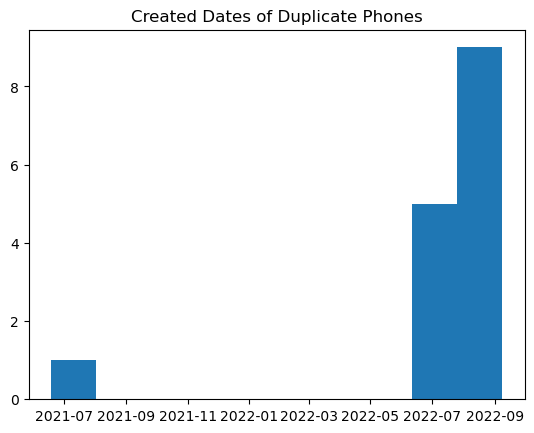

Count of phone numbers with dupicates:  9


,created,phone
id,,
42,2021-06-18 13:07:16,fd6fd0d9f630093f1767de2c165d87f53ed02e657cf198ca88700bf95b4bfdb3
54948,2022-07-12 14:37:29,4e4722efcdbfe297c4d38a37b256f6c3f9af96d3560cd1819c95f4fee7e005b1
54949,2022-07-12 14:38:17,9cacf2d4d5877546fc7f4134fd169a7e5a5e33acd342bdcdd6c33f249d6f5915
54951,2022-07-12 14:38:35,fca9f58030115749118c495af503d1e400df82aa347a49882e032944f45af86c
55426,2022-07-19 14:44:45,5efcf20d889b11e99ae9c47ccacbdce4ee4f2f8f2817430d30dce948c5a44752
55435,2022-07-20 02:44:28,d8b1d41a7961c7e98cb9da5609ffe2e12fa91e2f784511ff72d1b92b1cdc53e3
55473,2022-07-26 10:46:13,bdcec7ebdbca5c5aa4cffa5c7e4c6f0e32ca39d52bcd9c2dcf9e18cf05e90a55
55474,2022-07-26 10:55:06,4e4722efcdbfe297c4d38a37b256f6c3f9af96d3560cd1819c95f4fee7e005b1
55746,2022-08-16 12:53:05,fd6fd0d9f630093f1767de2c165d87f53ed02e657cf198ca88700bf95b4bfdb3


In [17]:
# Find duplicate phone numbers
def find_duplicate_phones(user_df):
    """Locates duplicate phone numbers in the user table

    Args:
        user_df (dataframe): the user table

    Returns:
        dataframe: dataframe of phone numbers with at least 1 duplicate
    """
    is_not_tester = user_df["tester"] == 1
    is_phone_duplicate = user_df["phone"].duplicated()
    return user_df.loc[is_not_tester & is_phone_duplicate, ["created", "phone"]]

all_duplicate_phones = find_duplicate_phones(user_df=user_df)

#Show distribution of when duplicates were created with histograms
import matplotlib.pyplot as plt
plt.hist(all_duplicate_phones["created"])
plt.title("Created Dates of Duplicate Phones")
plt.show()

print("Count of phone numbers with dupicates: ", all_duplicate_phones["phone"].nunique())

all_duplicate_phones

Despite the fact that phone numbers are altered with the multiprofile feature, there are still 9 phone numbers that have duplicates between all courses, including the most recent. Now let's look at the active field.

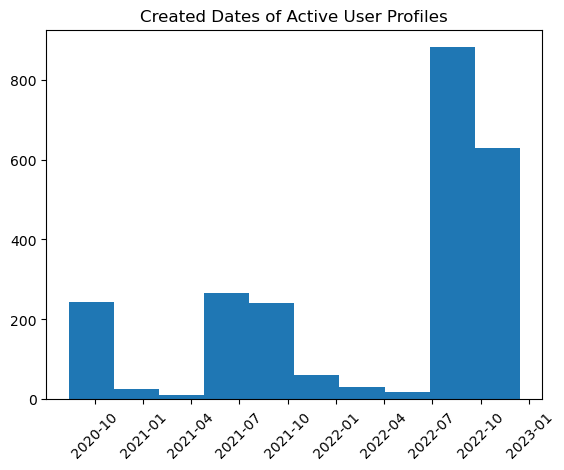

,created,active
id,,
44533,2021-09-03 10:38:57,1
4653,2020-09-03 17:06:23,1
57751,2022-09-13 11:26:17,1
44574,2021-09-03 16:34:17,1
61714,2022-09-18 14:15:06,1


In [18]:
#filter user table for active users
is_active = user_df["active"] == 1 
active_user_created = user_df.loc[is_active, ["created", "active"]]

import matplotlib.pyplot as plt
plt.hist(active_user_created["created"])
plt.title("Created Dates of Active User Profiles")
plt.xticks(rotation=45)
plt.show()

active_user_created.sample(5)

**TODO:** According to conversations with the data team, the CMU team was told that active users were implemented for course 3 yet, there are active user profiles going back to 2020. Is there a data issue or are these potentially previous users who returned for course 3?

## Registration Table
Let's look at the registration table.

In [19]:
registration_df = read_data(file_name="registration.pkl")
registration_df.sample(5)

,created,updated,course_id,user_id
id,,,,
2049,2021-06-22 02:57:13,2021-06-22 02:57:13,2,2322
683637,2022-09-22 19:33:33,2022-09-22 19:33:33,4,60633
43222,2021-07-14 17:37:46,2021-07-14 17:37:46,3,36001
38228,2021-07-02 10:22:12,2021-07-02 10:22:12,3,27268
5887,2021-06-22 03:07:05,2021-06-22 03:07:05,2,6276


The columns we have are

- `created DATETIME` - date registration record was created
- `updated DATETIME` - date registration record was updated
- `user_id INT (FK)` - id of user the was registered
- `course_id INT (FK)` - id of the course a user registered for

Some questions we might ask here are:
- How many users are have multiple course registrations? 
- What is the difference between a user being registered, enrolled, or active?

Let's have a closer look for a quick summary.

In [20]:
explore_data(registration_df)

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32955 entries, 1 to 684235
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   created    32955 non-null  object
 1   updated    32955 non-null  object
 2   course_id  32955 non-null  int64 
 3   user_id    32955 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ MB

Percentage of Missing Values
----------------------
created      0.0
updated      0.0
course_id    0.0
user_id      0.0
dtype: float64


,created,updated,course_id,user_id
count,32955,32955,32955.000000,32955.000000
unique,23361,23361,NaN,NaN
top,2021-06-22 02:52:14,2021-06-22 02:52:14,NaN,NaN
freq,12,12,NaN,NaN
mean,NaN,NaN,2.881384,26679.974723
std,NaN,NaN,0.831850,17694.144464
min,NaN,NaN,2.000000,1.000000
25%,NaN,NaN,2.000000,10896.000000
50%,NaN,NaN,3.000000,26850.000000
75%,NaN,NaN,3.000000,40234.000000


We have `32955 entries`. The data is very complete with no missing values.

### How many users are have multiple course registrations? 

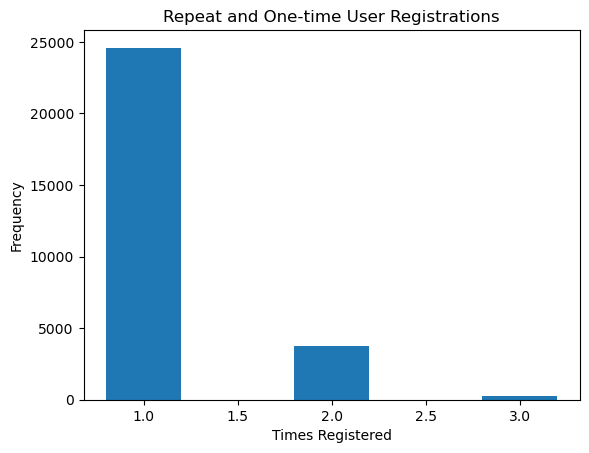

,counts,percentage
1,24587,0.858814
2,3758,0.131266
3,284,0.009920


In [21]:
registration_by_user = registration_df.groupby(registration_df["user_id"])

user_registration_counts = registration_by_user.size().value_counts()
user_registration_perc = registration_by_user.size().value_counts(normalize=True)


user_multi_registration = pd.concat([user_registration_counts, user_registration_perc], axis=1, keys=["counts", "percentage"])

plt.title("Repeat and One-time User Registrations")
plt.bar(x=user_multi_registration.index, height=user_multi_registration["counts"], width=0.4)
plt.xlabel("Times Registered")
plt.ylabel("Frequency")
plt.show()
user_multi_registration

Much more users have only registered for one course so far with **less than 15%** of users participating more than one course. 

### Questions
❗️***TODO:*** We can ask an additional questions:
- How many returning users came back to course 3. Being a returning user could be relevant for predicting outcomes. 
- Are people who previously registered for a previous course more likely to complete than first time registrants? 

## Course Table
Let's look at the course table.

In [22]:
course_df = read_data("course.pkl")
course_df

,created,updated,title,path,status,start,stop
id,,,,,,,
1,2022-06-15,2022-06-15,Yiya Testers,NaN,inactive,2022-01-01,NaN
2,2022-06-15,2022-06-15,Course 1,None,inactive,NaN,NaN
3,2022-06-15,2022-06-15,Course 2,course-spring-2021,inactive,2021-08-01,2021-10-31
4,2022-06-15,2022-06-15,Course 3,airscience-2022a,active,2022-08-11,2022-10-31
5,2022-06-15,2022-06-15,Course 3,airscience-2022b,active,2022-08-11,2022-10-31


The course table has the following fields:
- created DATETIME - date course record was created
- updated DATETIME - ...
- title VARCHAR(255) - title of course
- path VARCHAR(255) - seems to be part of an endpoint route for the system
- status ENUM(...) - designates whether course is currently running (active or inactive)
- start DATETIME - course start (TODO: What marks starts the course, registration opening or first lesson?)
- stop DATETIME - course stop date (TODO: What marks starts the course, registration opening or first lesson?)

There's an additional issue of the course dates recorded in the table not being exact. 

In [23]:
explore_data(course_df)

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 1 to 5
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   created  5 non-null      datetime64[ns]
 1   updated  5 non-null      datetime64[ns]
 2   title    5 non-null      object        
 3   path     4 non-null      object        
 4   status   5 non-null      object        
 5   start    4 non-null      object        
 6   stop     3 non-null      object        
dtypes: datetime64[ns](2), object(5)
memory usage: 320.0+ bytes

Percentage of Missing Values
----------------------
created     0.0
updated     0.0
title       0.0
path       20.0
status      0.0
start      20.0
stop       40.0
dtype: float64


,created,updated,title,path,status,start,stop
count,5,5,5,4,5,4,3
unique,NaN,NaN,4,4,2,3,2
top,NaN,NaN,Course 3,None,inactive,2022-08-11,2022-10-31
freq,NaN,NaN,2,1,3,2,2
mean,2022-06-15 00:00:00,2022-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN
min,2022-06-15 00:00:00,2022-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN
25%,2022-06-15 00:00:00,2022-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN
50%,2022-06-15 00:00:00,2022-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN
75%,2022-06-15 00:00:00,2022-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN
max,2022-06-15 00:00:00,2022-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN


Here the start and stop columns need to be converted to datetime objects for time calculation. According to the data team the revised course date for course 3 was `12-28-2022`. Let's create a revised date so each course spans 20 weeks. With the current start dates, the course end is set to slightly before new years day.

In [24]:
import datetime as dt

def update_course_stop(course_temp_df, weeks_of_duration=20):
    """Create a standardized revised_stop date for course duration so courses 
        are compared in the same timeframe

    Args:
        course_temp_df (_df_): course table dataframe
        weeks_of_duration (_int_): weeks the course should last

    Returns:
        _df_: new course data frame with revised_stop column
    """
    course_temp_df = course_df.copy() #copy of course table

    #convert start and stop to datetime
    course_temp_df["start"] = pd.to_datetime(course_temp_df["start"])
    course_temp_df["stop"] = pd.to_datetime(course_temp_df["stop"])

    #add reised stop column with the weeks of duration added from the start date
    course_temp_df["revised_stop"] =  course_temp_df["start"] + dt.timedelta(weeks=weeks_of_duration)

    return course_temp_df

## NOTE: CHANGE THE COURSE DURATION HERE IF NEEDED!
course_df = update_course_stop(course_temp_df=course_df, weeks_of_duration=20)
course_df


,created,updated,title,path,status,start,stop,revised_stop
id,,,,,,,,
1,2022-06-15,2022-06-15,Yiya Testers,NaN,inactive,2022-01-01,NaT,2022-05-21
2,2022-06-15,2022-06-15,Course 1,None,inactive,NaT,NaT,NaT
3,2022-06-15,2022-06-15,Course 2,course-spring-2021,inactive,2021-08-01,2021-10-31,2021-12-19
4,2022-06-15,2022-06-15,Course 3,airscience-2022a,active,2022-08-11,2022-10-31,2022-12-29
5,2022-06-15,2022-06-15,Course 3,airscience-2022b,active,2022-08-11,2022-10-31,2022-12-29


## Telecomsesion Table

Let's look at the  telecomsession table. It's the largest and can give insight to how students interact with certain types of content. 

- Status:
    - not answered: connected but user didn't pick up
    - succeeded:  user picked up
    - failed: call did not connect

In [25]:
#The table is large so we'll adjust column with temporarily

telecomsession_df = read_data("telecomsession.pkl")
telecomsession_df.sample(3, random_state=5)

,created,updated,session_id,channel_id,telecom_date,user_initiated,network_code,service_code,status,status_reason,cost,cost_string,duration_in_millis,hops,user_input,final_output
id,,,,,,,,,,,,,,,,
1668337,2022-12-14 16:03:55,2022-12-14 16:03:55,ATUid_67ce64b2bf9ef0a7115d15b003d54569,4447,2022-12-14 16:03:54,1,64110,*284*19#,Incomplete,NaN,320.0,UGX 320.0000,152018,7.0,91eba2dfc2aef21f4aa96f56792d0aef864321b625b2e14906cd704a09d8479c,CON OKELLO Choose 1-4\n6/10: Bodas/cars are going too fast on the road near your home. What do you do?\n1. I make a plan and advise the local leadership\n2. I mobilize the community\n3. I hope someone does something\n4. I try to fix the road myself
681729,2021-08-26 17:06:06,2021-08-26 17:06:06,ATUid_8d056396d4d8fa433bbdb0c3376411d2,81095,2021-08-26 17:06:06,1,64101,*284*19#,Incomplete,NaN,165.0,UGX 165.0000,20352,1.0,e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,"CON To create a solar cell, add Titanium dioxide paste on a metal strip. Add Hibiscus dye on top of the paste, leave to dry. Cover with a paper & add iodine solution.\n1. Go to questions"
1244281,2022-03-23 13:16:28,2022-03-23 13:16:28,ATXid_81c8dc67049f73172d6e5f36f9c30534,140181,NaN,0,64110,NaN,Success,NaN,0.0,NaN,0,NaN,NaN,NaN


We have following tables:
- `created DATETIME` - date and time telecomsession was started and recorded
- `updated DATETIME` - 
- `session_id VARCHAR(255)` - TODO: How is this different from the id of the table?
- `channel_id INT (FK)` - links to the channel table, which can gve more context to what the user received from the system
- `telecom_date DATETIME`- date and time telecomsession was started
- `user_initiated TINYINT(1)` - indicates whether session was started by user (1) or course system whether USSD, robocal or other medium
- `network_code VARCHAR(255)` - TODO: What do network codes indicate?
- `service_code VARCHAR(255)` -  TODO: What do service codes indicate?
- `status VARCHAR(255)` - based on previous discussion, this indicate if and how communication reached user
- `status_reason VARCHAR(255)` - TODO: needs closer inspection
- `cost FLOAT` - cost of in the call in UGX
- `cost_string VARCHAR(255)` - cost of the call in UGX with currency noted
- `duration_in_millis INT` - how long the call lasted.
- `hops INT` - TODO: Explanation Needed
- `user_input VARCHAR(255)` - raw user input, which has been hashed for privacy
- `final_output VARCHAR(255)` - TODO: Explanation needed. Does this show the last thing the system sent to user before the session ended?

In [26]:
explore_data(telecomsession_df)

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1696526 entries, 1 to 1696859
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   created             datetime64[ns]
 1   updated             datetime64[ns]
 2   session_id          object        
 3   channel_id          int64         
 4   telecom_date        object        
 5   user_initiated      int64         
 6   network_code        object        
 7   service_code        object        
 8   status              object        
 9   status_reason       object        
 10  cost                float64       
 11  cost_string         object        
 12  duration_in_millis  int64         
 13  hops                float64       
 14  user_input          object        
 15  final_output        object        
dtypes: datetime64[ns](2), float64(2), int64(3), object(9)
memory usage: 220.0+ MB

Percentage of Missing Values
---------

,created,updated,session_id,channel_id,telecom_date,user_initiated,network_code,service_code,status,status_reason,cost,cost_string,duration_in_millis,hops,user_input,final_output
count,1696526,1696526,1696526,1.696526e+06,754587,1.696526e+06,1696526,829927,1696526,73187,1.696497e+06,999600,1.696526e+06,754587.000000,829927,732339
unique,NaN,NaN,1683104,NaN,694214,NaN,8,3,8,19,NaN,195,NaN,NaN,108011,28382
top,NaN,NaN,ATVId_ec9a0df1d2b88e2955c25e86c525735d,NaN,2022-09-19 17:00:06,NaN,64110,*284*19#,Success,SUBSCRIBER_ABSENT,NaN,0.0,NaN,NaN,e3b0c44298fc1c149afbf4c8996fb92427ae41e4649b934ca495991b7852b855,END Thank you for answering lesson questions!
freq,NaN,NaN,3,NaN,18,NaN,1314227,754587,981137,38903,NaN,169673,NaN,NaN,232692,92106
mean,2021-12-20 19:13:37.839655424,2021-12-20 19:13:38.224569344,NaN,9.693402e+04,NaN,4.447836e-01,NaN,NaN,NaN,NaN,7.073558e+01,NaN,2.947735e+04,4.410262,NaN,NaN
min,2021-06-17 15:53:28,2021-06-17 15:53:28,NaN,1.000000e+00,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,1.000000,NaN,NaN
25%,2021-08-03 09:41:17,2021-08-03 09:41:17,NaN,5.972700e+04,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,2.000000,NaN,NaN
50%,2021-09-20 09:56:52,2021-09-20 09:56:52,NaN,9.707100e+04,NaN,0.000000e+00,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,4.000000,NaN,NaN
75%,2022-06-24 15:27:01.249999872,2022-06-24 15:27:01.249999872,NaN,1.271730e+05,NaN,1.000000e+00,NaN,NaN,NaN,NaN,1.200000e+02,NaN,4.417200e+04,6.000000,NaN,NaN
max,2022-12-28 17:14:46,2022-12-28 17:14:46,NaN,2.351730e+05,NaN,1.000000e+00,NaN,NaN,NaN,NaN,2.310000e+03,NaN,6.257390e+05,57.000000,NaN,NaN


We have `1,683,104` unique sessions as if the collection of this data. Let's add a column of duration in seconds so session length is easier to understand and see the distibution of user initiatied sessions. 

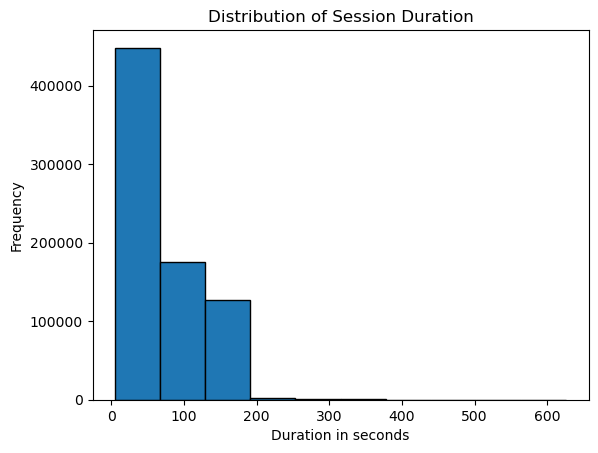

count    1.696526e+06
mean     2.947735e+01
std      4.712324e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.417200e+01
max      6.257390e+02
Name: duration_in_sec, dtype: float64


In [27]:
telecomsession_df["duration_in_sec"] = telecomsession_df["duration_in_millis"] / 1000

plt.title("Distribution of Session Duration")
plt.ylabel("Frequency")
plt.xlabel("Duration in seconds")
plt.ticklabel_format(axis='both', style='plain')
plt.hist(telecomsession_df.loc[(telecomsession_df["user_initiated"] == 1),"duration_in_sec"], edgecolor = "black")
plt.show()

print(telecomsession_df["duration_in_sec"].describe())

Many user initiated sessions are very short with 50% of them lasting less than a second with the longest session.. If necessary, we can filter for sessions longer than 1 second to avoid sessions the may be triggered by... TODO: Ask Tech team what triggers end of session.

### Questions
For completion and usage gap prediction, relevant factors may be
- Do users who complete have more sessions per week? 
- Do users who complete have longer sessions on average? 
- How many sessions a user initiates on average by week
- The average length of a user's session
- Number of times they listened to robocalls to preview the lesson

## Task Table
Course III Schedules for Registered:
https://live.airscience.yiyasolutions.org/simulator/schedules

In [28]:
task_df = read_data("task.pkl")
task_df.sample(5)

,created,updated,user_id,script,complete
id,,,,,
116851,2021-09-16 16:48:35,2021-09-16 16:48:35,45631,content/onboarding,1
174458,2022-10-02 09:31:05,2022-10-02 09:31:05,59033,content/yiya-airscience-tests-2021/intro-step-test,1
96756,2021-08-26 10:15:38,2021-08-26 10:15:38,37743,content/course-spring-2021/step-5-create/step-5-lesson-4,1
143958,2021-10-26 14:38:06,2021-10-26 14:38:06,45377,content/endline-survey,1
155053,2021-12-03 07:50:25,2021-12-03 07:50:25,11204,content/course-spring-2021/assessment-questions,1


In [29]:
explore_data(task_df)

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 211554 entries, 1 to 211621
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   created   211554 non-null  datetime64[ns]
 1   updated   211554 non-null  datetime64[ns]
 2   user_id   211554 non-null  int64         
 3   script    211554 non-null  object        
 4   complete  211554 non-null  int64         
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.7+ MB

Percentage of Missing Values
----------------------
created     0.0
updated     0.0
user_id     0.0
script      0.0
complete    0.0
dtype: float64


,created,updated,user_id,script,complete
count,211554,211554,211554.000000,211554,211554.000000
unique,NaN,NaN,NaN,123,NaN
top,NaN,NaN,NaN,content/onboarding,NaN
freq,NaN,NaN,NaN,20942,NaN
mean,2021-12-04 16:07:25.709516288,2021-12-04 22:03:53.696432128,34503.272649,NaN,0.997925
min,2021-06-21 05:37:53,2021-06-22 16:07:58,1.000000,NaN,0.000000
25%,2021-07-26 10:10:42.750000128,2021-07-26 10:33:06.500000,25779.000000,NaN,1.000000
50%,2021-09-03 16:35:05,2021-09-03 17:47:20.500000,34059.000000,NaN,1.000000
75%,2021-12-29 18:57:53,2021-12-31 06:25:12.500000,44392.000000,NaN,1.000000
max,2022-12-28 13:55:05,2022-12-28 13:55:05,70815.000000,NaN,1.000000


To date we have `211,554` task completions. The script seems to be the same as other tables. 


TODO: Compare script table in columns where they appear to verify that they are they are using the about same scripts.
For the scripts, we need to generate a summary of
- how many questions were  in he tasks
- when the task was released (or as a proxy, when the task was first completed by a non tester user)

TODO: Another potential issue is that the complete column. of the complete column is a zero. When were 0s entered?

Completed Value Counts
1    0.997925
0    0.002075
Name: complete, dtype: float64


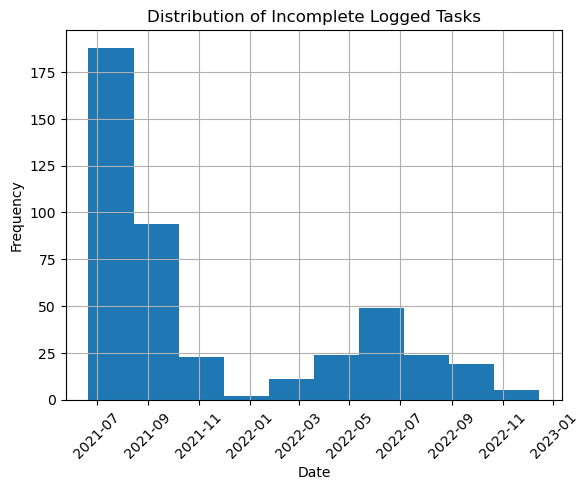

Sample of Icompleted Logged Scripts
id
160589              content/yiya-airscience-tests-2021/intro-step-test
160623        content/course-spring-2021/step-5-create/step-5-lesson-4
160606                content/solar-food-dryer/create-solar-food-dryer
76728     content/course-spring-2021/step-3-brainstorm/step-3-lesson-3
Name: script, dtype: object


,created,updated,user_id,script,complete
count,439,439,439.000000,439,439.0
unique,NaN,NaN,NaN,86,NaN
top,NaN,NaN,NaN,content/onboarding,NaN
freq,NaN,NaN,NaN,40,NaN
mean,2021-11-13 11:53:12.460136704,2022-03-12 18:54:18.476081920,15617.822323,NaN,0.0
min,2021-06-21 05:37:53,2021-06-22 16:07:58,35.000000,NaN,0.0
25%,2021-07-23 09:24:00,2021-10-22 12:39:25,37.000000,NaN,0.0
50%,2021-08-25 09:14:52,2022-05-23 12:36:19,40.000000,NaN,0.0
75%,2022-04-21 09:22:01.500000,2022-07-12 14:19:56,26263.000000,NaN,0.0
max,2022-12-15 07:23:57,2022-12-26 07:19:53,55865.000000,NaN,0.0


In [30]:
print("Completed Value Counts")
print(task_df["complete"].value_counts(normalize=True))

complete_is_0 = (task_df["complete"] == 0)
task_complete_is_0 = task_df.loc[complete_is_0, :]

#Create distribution of dates where complete field is 0

task_complete_is_0["created"].hist()
plt.title("Distribution of Incomplete Logged Tasks")
plt.ylabel("Frequency")
plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.show()

print("Sample of Icompleted Logged Scripts")
print(task_complete_is_0["script"].sample(4, random_state=5))

task_complete_is_0.describe(include="all", datetime_is_numeric=True)


### Explaining Incomplete Logged Tasks
It's not clear why there are incomplete tasks logged, but the amount is insignificant enough to be ignored. Only 0.2% of tasks logged are marked as incomplete. This seems to be happening throughout the duration of the system. but the reason is unclear. **NOTE:** Whether or not this is an issue to investigate in the system will be left up to Yiya's tech team. 

## Response Table

Response table logs all responses for users from the course menu and tasks like lessons, tests, surveys, or exams. Let's look at the response table. 

In [31]:
response_df = read_data(file_name="response.pkl")
response_df.sample(10, random_state=5)

,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
350758,2021-07-21 10:10:49,2021-07-21 10:10:49,38080,689443,profile/access#internet,No,0
1326640,2022-10-12 05:30:04,2022-10-12 05:30:04,60765,2634967,airscience-2022a/course/tests/step-1-test#q1-what-are-the-first-2-steps-of-the-engineering-process,"Identify, investigate",1
1139735,2022-07-12 22:51:44,2022-07-12 22:51:44,53007,2290362,course-menu,My Profile,0
1132758,2022-03-25 16:35:48,2022-03-25 16:35:48,33888,2274590,solar-food-dryer/create-solar-food-dryer/go-to-questions#q3,A transparent polyethene material,1
1534892,2022-12-16 20:05:40,2022-12-16 20:05:40,56640,2991974,airscience-2022a/course/tests/step-10-test#learn-more-about-it/question-11-to-create-a-homemade-detergent-you-need,"Baking powder, water, bar soap and salt",1
1131807,2022-03-25 11:15:42,2022-03-25 11:15:42,2820,2271954,solar-food-dryer/create-solar-food-dryer/go-to-questions#q2,Transfer of solar energy in space,1
987021,2021-11-01 05:03:25,2021-11-01 05:03:25,48450,2018447,course-spring-2021/step-2-investigate/step-2-lesson-4/go-to-questions#q1,Water and carbon dioxide and the sun,0
1205602,2022-09-17 17:46:07,2022-09-17 17:46:07,59548,2401213,airscience-2022a/course/baseline-survey#question-5-generally-earn-per-week,I’m not sure,0
1015174,2021-11-03 04:10:09,2021-11-03 04:10:09,23916,2063402,course-spring-2021/assessment-questions/go-to-exam-questions#q10,Total cost of materials + Labour + profit,1


The fields we have are: 
- id INT
- created DATETIME - time user response was received
- updated DATETIME
- source_id INT (FK) - link to outbound
- user_id INT (FK) - identifier for user
- key VARCHAR(255) - unique identifier and endpoint for question
- value VARCHAR(255) - option selected by user
- correct TINYINT(1) - whether response was correct. 

Things like "course-spring-2021/step-2-investigate/step-2-lesson-4/go-to-questions#q1" is a redundant state. Go to questions connects to a child page. Test questions are primary pages. 


In [32]:
explore_data(response_df)

Information on Fields
----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564609 entries, 1 to 1565106
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   created    1564609 non-null  datetime64[ns]
 1   updated    1564609 non-null  datetime64[ns]
 2   user_id    1564609 non-null  int64         
 3   source_id  1564609 non-null  int64         
 4   key        1564609 non-null  object        
 5   value      1564003 non-null  object        
 6   correct    1564609 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 95.5+ MB

Percentage of Missing Values
----------------------
created      0.000000
updated      0.000000
user_id      0.000000
source_id    0.000000
key          0.000000
value        0.038732
correct      0.000000
dtype: float64


,created,updated,user_id,source_id,key,value,correct
count,1564609,1564609,1.564609e+06,1.564609e+06,1564609,1564003,1.564609e+06
unique,NaN,NaN,NaN,NaN,564,21862,NaN
top,NaN,NaN,NaN,NaN,course-menu,Yes,NaN
freq,NaN,NaN,NaN,NaN,115905,118943,NaN
mean,2021-12-22 03:19:50.093245440,2021-12-22 03:19:50.093261056,3.605093e+04,1.575219e+06,NaN,NaN,1.027349e-01
min,2021-06-20 08:33:58,2021-06-20 08:33:58,1.000000e+00,4.000000e+00,NaN,NaN,0.000000e+00
25%,2021-07-26 08:07:14,2021-07-26 08:07:14,2.657100e+04,7.779380e+05,NaN,NaN,0.000000e+00
50%,2021-09-21 10:05:05,2021-09-21 10:05:05,3.590100e+04,1.644268e+06,NaN,NaN,0.000000e+00
75%,2022-09-14 14:03:00,2022-09-14 14:03:00,4.668900e+04,2.347999e+06,NaN,NaN,0.000000e+00
max,2022-12-28 13:55:05,2022-12-28 13:55:05,7.744500e+04,3.036640e+06,NaN,NaN,1.000000e+00


### Types of Keys
Keys identify unique paths in sysrtem that can lead to menu items, lesson questions, test questions, or survey questions

In [76]:
#Test
contains_test = response_df["key"].str.contains("test")
response_df.loc[contains_test, "key"].drop_duplicates()

id
300754                                                                                                                                                            yiya-airscience-tests-2021/intro-step-test#q-1
300755                                                                                                                                                            yiya-airscience-tests-2021/intro-step-test#q-2
300757                                                                                                                                                            yiya-airscience-tests-2021/intro-step-test#q-3
300758                                                                                                                                                            yiya-airscience-tests-2021/intro-step-test#q-4
300760                                                                                                                                                           

# Predicting Usage Gaps and Dropout

We will use classification models to predict whether a user while stop interacting with the course system for more than 8 days as a measure of a usage gap. We will also try predict whether a user will send their last message before completing the standard completion criteria (attempting least 60% of lesson questions and at least 40% of tests question). We aim to predict usage gaps and dropout at the time of each users most recent message.

The classification models we will attempt are:
- Logistic Regression
- Random Forest Classifier

**Key Prediction Questions**
We are trying to predict: 
- Will a user stop sending response to the system within the next week?
- Will a user stop sending responses to the system for the rest of the course?

We can calculate these features cumulatively and within a rolling window of 3 weeks for the user:
- days_active_in_week	
- l_q_unique	
- t_q_unique	
- total_weekly_responses
- which day of the week they used it most - Hypothesis: People who use the system the most the day before the broadcast are more likely to have usage gaps (Procastinators)
- whether they used it most during broadcast day - Hypo: People who use it most during broadcast day are less likely to have a usage gap the following week
- average session times
- count of unique sessions
- And accumlated version of the aforementioned where it makes sense

We'll pick up at 3:45 pm. 

Related work
- https://www.researchgate.net/profile/Anja-Lorenz/publication/263543544_Open_Online_Courses_in_the_context_of_higher_education_an_evaluation_of_a_German_cMOOC/links/54941c560cf2e1b6095f97bc/Open-Online-Courses-in-the-context-of-higher-education-an-evaluation-of-a-German-cMOOC.pdf#page=58 


Steps tp expanding response table
- Create a function that accepts the response, user, and course table as a parameter
- Filter the response table by the course date, registration status, non tester status NOTE: See how many users may have been lost in course 3 due to
- 

These are the labels we need on course response
- response type {menu, lesson, test, exam}
#- correct value

## Last Response Approach

### Filtering Response with Data Inclusion Criteria
First we're going to restrict the responses to a specific course. We'll start with course 2.

In [111]:
def get_registered_users(registration_df, course_ids):
    """Returns the list of user ids registered with the specified course ids

    Args:
        registration_df (dataframe): the registration table
        course_ids (_type_): _description_

    Returns:
        numpy array: array of user ids
    """
    has_course_id = registration_df["course_id"].isin(course_ids) #build a mask for rows that have selected course ids
    registered_users_lst = registered_users_lst.loc[has_course_id, "user_id"]

    return registered_users_lst

def get_course_responses(course_start, duration, course_ids):
    """_summary_: gets responses from users that have completed the baseline in within specific course isntances

    Args:
        course_start (_type_): _description_
        duration (_type_): _description_
        course_ids (_type_): _description_

    Returns:
        _type_: _description_
    """
    #Look at the course table for the specific course you want.
    # course_start = pd.to_datetime("2021-08-01")
    # duration = dt.timedelta(weeks=20)
    course_stop = course_start + duration

    #Course IDS
    #course_ids = [3]

    # Identify registered users registered for the course with registration table
    has_course_id = registration_df["course_id"].isin(course_ids)
    user_registrations = registration_df.loc[has_course_id]
    print("registered users")
    print(user_registrations["user_id"].head())

    #identity testers
    is_tester = user_df["tester"] == 1
    testers = user_df.loc[is_tester]
    print("tester ids")
    print(testers.index)

    #users who completed baseline task
    #get users who completed baselines
    contains_baseline = task_df["script"].str.contains("baseline") #task script contains baseline
    between_dates = (task_df["created"] >= course_start) & (task_df["created"] <= course_stop) #task completed within course dates
    completed_baseline_tasks = task_df.loc[contains_baseline & between_dates] #
    print("BASELINE TASK SAMPLE")
    print(completed_baseline_tasks.sample())
    completed_baseline_tasks.info()
    print("BASELINE TASK SCRIPT")
    print(completed_baseline_tasks["script"].unique())
    print()

    #Get resposnes from users who are registered, have completed the baseline, and send a message between course dates
    is_response_between_dates = (response_df["created"] >= course_start) & (response_df["created"] <= course_stop) #response sent within course dates?
    has_user_completed_baseline = response_df["user_id"].isin(completed_baseline_tasks["user_id"]) #response sent by user who completed baseline?
    is_response_from_non_tester = ~(response_df["user_id"].isin(testers))

    response_meets_criteria = is_response_between_dates & has_user_completed_baseline & is_response_from_non_tester
    return response_df.loc[response_meets_criteria]

#EDIT COURSES TO TRAIN ON HERE
#For course 2
#Refer to the course table for the courses you want to train on
course_start = pd.to_datetime("2021-08-01")
duration = dt.timedelta(weeks=20)
course_stop = course_start + duration

#Course IDS
course_ids = [3]

response_course_2_df = get_course_responses(course_start=course_start, duration=duration, course_ids=course_ids)
response_course_2_df 


registered users
id
32768     1
32769     3
32770     5
32771    13
32772    14
Name: user_id, dtype: int64
tester ids
Int64Index([    4,    13,    35,    36,    37,    38,    39,    40,    41,
               42,
            ...
            76252, 76253, 76254, 76255, 76256, 76258, 76260, 76538, 76539,
            77445],
           dtype='int64', name='id', length=890)
BASELINE TASK SAMPLE
                   created             updated  user_id  \
id                                                        
150147 2021-11-06 06:23:26 2021-11-06 06:23:26    50027   

                            script  complete  
id                                            
150147  content/baseline-questions         1  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5049 entries, 61162 to 157689
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   created   5049 non-null   datetime64[ns]
 1   updated   5049 non-null   dateti

,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
434312,2021-08-01 01:13:43,2021-08-01 01:13:43,38842,876772,baseline-questions#why-yiya-airscience,Pass exam,0
434313,2021-08-01 01:13:56,2021-08-01 01:13:56,38842,876773,baseline-questions#why-yiya-airscience/school-enrolment,Yes,0
434314,2021-08-01 01:15:08,2021-08-01 01:15:08,38842,876775,baseline-questions#why-yiya-airscience/past-experience-with-stem,Yes,0
434315,2021-08-01 01:15:37,2021-08-01 01:15:37,38842,876776,baseline-questions#why-yiya-airscience/love-for-stem,Definitely,0
434316,2021-08-01 01:16:01,2021-08-01 01:16:01,38842,876777,baseline-questions#why-yiya-airscience/interest-in-a-job-in-stem,Not sure,0
...,...,...,...,...,...,...,...
1113381,2021-12-18 20:32:41,2021-12-18 20:32:41,49371,2232177,yiya-airscience-tests-2021/intro-step-test#q-2,Phone,0
1113382,2021-12-18 20:32:56,2021-12-18 20:32:56,49371,2232178,yiya-airscience-tests-2021/intro-step-test#q-3,Solids,0
1113383,2021-12-18 20:33:27,2021-12-18 20:33:27,49371,2232179,yiya-airscience-tests-2021/intro-step-test#q-4,The process of using science and mathematics to simplify life,0


In [219]:
df = pd.DataFrame({"B": [0, 1, 2, np.nan, 4]})
df["A"] = df["B"] + 1
display(df)

df.expanding(1).sum()


,B,A
0,0.0,1.0
1,1.0,2.0
2,2.0,3.0
3,NaN,NaN
4,4.0,5.0


,B,A
0,0.0,1.0
1,1.0,3.0
2,3.0,6.0
3,3.0,6.0
4,7.0,11.0


### Feature Engineering Usage Gap Calculation

In this section, we generate features of responses that may be indicative of usage gap and dropout. 
Features we need to be logged automatically
- whether a answer is correct
- which lesson or test a response belongs too
- response type: intermittent survey, lesson, test, baseline, endline

In [221]:
def calculate_usage_gap(time):
    """calculates if time between response is usage gap

    Args:
        time (_datetime_): _element_
    """
    #flag as usage gap if more than 8 days
    if time >= 8:
        return 1
    else:
        return 0

def is_user_behind(single_user_responses, all_responses):
    """determines if user is behind by comparing the number of
    unique keys that exist in the dataframe of all for credit question
    keys. 

    Args:
        single_user_responses (dataframe): _description_
        all_responses (_type_): _description_
    """

    #TODO: Better just to let things be

    #Get time of user's most recent response
    user_most_recent__resp = single_user_responses["created"].max()

    # Filter all_response dataframe with responses up to the user's most recent call and take the key column
    #TODO: Add the condition that keys are lesson or test questions in .loc row select
    contains_lesson_or_test = all_responses_keys["key"].str.contains("test|lesson")
    all_responses_keys = all_responses.loc[all_responses["created"] < user_most_recent__resp, "key"]
    all_responses_keys_nunique = all_responses_keys.nunique() #unique


    pass

def generate_features_by_user(df):
    """returns response dataframe generates features for response table to be used in predictions

    Args:
        df (_type_): key column of responses
    """
    
    #response_gap - calculate time gap between last and current response based on created date in days
    df["resp_gap"] = df["created"].dt.day.diff().abs() #absolute value to value is positive e.g abs(day 1 - day 3)= abs(-2) = 2
    df["resp_gap"] = df["resp_gap"].fillna(0) #fill NaN left in first message rows

    #total_response_gap - accumulation of time between responses
    df["total_resp_gap"] = df["resp_gap"].cumsum()

    #rolling_resp_count - count of responses in last 7 days
    df["rolling_resp_count"] = df.rolling(window="7D", on="created")["source_id"].count() #using source id because column is a complete int

    #user_behind
    #df.expanding().apply(is_user_behind)
   


    #Rolling Average Response Gap

    #TODO: days_absent - total time in between responses where resp1gap is more than 1 day + time sinc
    #time since course start = created - course_start
    #time since course start + 
    #(space between the start of the course and the first message) + resp_gap if completion criteria not met.

    #usage_gap - identify user gaps based on amount of time between responses
    df["is_usage_gap"] = df["resp_gap"].apply(calculate_usage_gap)

    #TODO: precedes_user_gap - response was sent before a usage gap, shift usage_gap column by -1
    df["precedes_usage_gap"] = df["is_usage_gap"].shift(-1)
    
    

    #TODO: sent_during_broadcast

    #TODO: answer_is_correct - This needs to be lined up with the content table some how

    ##TODO: step_unit - whether baseline, endline, 


    #keys_used - calculate how many unique keys a user has responded to up to each response, proxy for amount of system explored
    #count the key if it is not a duplicate
    key_not_duplicate = ~df["key"].duplicated()
    df['unique_keys_used'] = (key_not_duplicate).cumsum()

    #test_questions_done - calculate how many unique keys a user has responded to up to each response, proxy for amount of system explored
    key_is_test_question = df["key"].str.contains("test")
    df['unique_test_questions'] = (key_not_duplicate & key_is_test_question).cumsum()

    #lesson_questions_done - calculate how many unique lesson keys a user has responded to up to each response, 
    key_is_lesson_question = df["key"].str.contains("lesson")
    df['unique_lesson_questions'] = (key_not_duplicate & key_is_lesson_question).cumsum()

    #for_credit_questions_done - how much lesson and test questions the user has done.
    df['for_credit_questions_done'] = df['unique_test_questions'] + df['unique_lesson_questions']

    
    #user_is_behind - whether the user has done #
    
    """
    select a copy of df between start date and date you want (end)
    select rows that have the desired keys e.g contains (yiya-airscience-tests-2021)
    group by and count the unique keys 
    """

    #how many unique questions attempted to date
    #count how many 

    #how many responses sent to date

    return df



# correct
# response_features.columns.loc["correct"]

"""
Apply only to users with a usage_gap
"""

response_features = response_course_2_df.groupby([response_course_2_df["user_id"]], group_keys=True).apply(generate_features_by_user)
response_features

created             updated  user_id  source_id  \
user_id id                                                                    
19      1064391 2021-11-16 18:03:55 2021-11-16 18:03:55       19    2143637   
        1064392 2021-11-16 18:04:13 2021-11-16 18:04:13       19    2143638   
        1064393 2021-11-16 18:04:20 2021-11-16 18:04:20       19    2143639   
        1064394 2021-11-16 18:04:35 2021-11-16 18:04:35       19    2143641   
        1064395 2021-11-16 18:04:47 2021-11-16 18:04:47       19    2143642   
...                             ...                 ...      ...        ...   
51436   1113274 2021-12-18 18:15:10 2021-12-18 18:15:10    51436    2231969   
        1113275 2021-12-18 18:15:24 2021-12-18 18:15:24    51436    2231970   
        1113276 2021-12-18 18:15:33 2021-12-18 18:15:33    51436    2231971   
        1113277 2021-12-18 18:15:47 2021-12-18 18:15:47    51436    2231972   
        1113278 2021-12-18 18:16:05 2021-12-18 18:16:05    51436    2231973   

                                                                              key  \
user_id id                                                                          
19      1064391                                                profile/given-name   
        1064392                                                   profile/surname   
        1064393                                                    profile/gender   
        1064394                                                       profile/age   
        1064395                                        profile/preferred-language   
...                                                                           ...   
51436   1113274              baseline-questions#why-yiya-airscience/love-for-stem   
        1113275  baseline-questions#why-yiya-airscience/interest-in-a-job-in-stem   
        1113276      baseline-questions#why-yiya-airscience/current-income-status   
        1113277            baseline-questions#why-yiya-airscience/problem-solving   
        1113278                 baseline-questions#why-yiya-airscience/resilience   

                                                                            value  \
user_id id                                                                          
19      1064391  7349cce7144bcb471a3e5dae4730d15a2e7e766378fff42ddfccbadaa537f372   
        1064392  63b063f5b637a3e8ced50585a954606c637c30a9211c4dedfd508dedcbd5c060   
        1064393                                                              Male   
        1064394                                                                36   
        1064395                                                           English   
...                                                                           ...   
51436   1113274                                                        Definitely   
        1113275                                                        Definitely   
        1113276                                                                No   
        1113277                                                      Occasionally   
        1113278                     Try a different solution to achieve your goal   

                 correct  resp_gap  total_resp_gap  rolling_resp_count  \
user_id id                                                               
19      1064391        0       0.0             0.0                 1.0   
        1064392        0       0.0             0.0                 2.0   
        1064393        0       0.0             0.0                 3.0   
        1064394        0       0.0             0.0                 4.0   
        1064395        0       0.0             0.0                 5.0   
...                  ...       ...             ...                 ...   
51436   1113274        0       0.0             0.0                17.0   
        1113275        0       0.0             0.0                18.0   
        1113276        0       0.0             0

### Visualize Usage Patterns

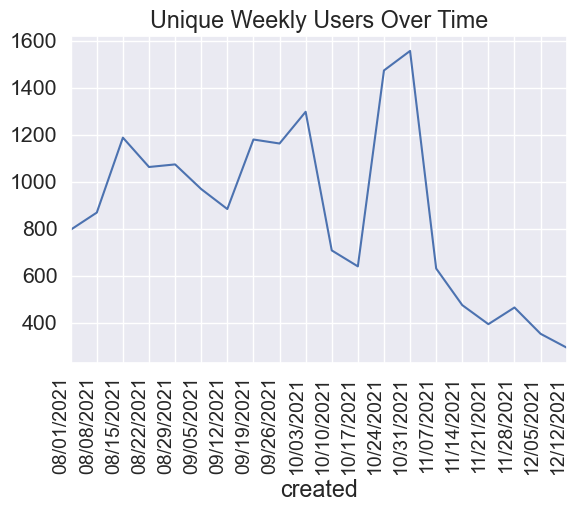

In [172]:
import matplotlib.dates as mdates
weekly_resample = response_features.resample("7D", on="created")

plt.title("Unique Weekly Users Over Time")

weekly_resample["user_id"].nunique().plot()
#weekly_resample["user_id"].size().plot()


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=14, rotation=90)
plt.show()

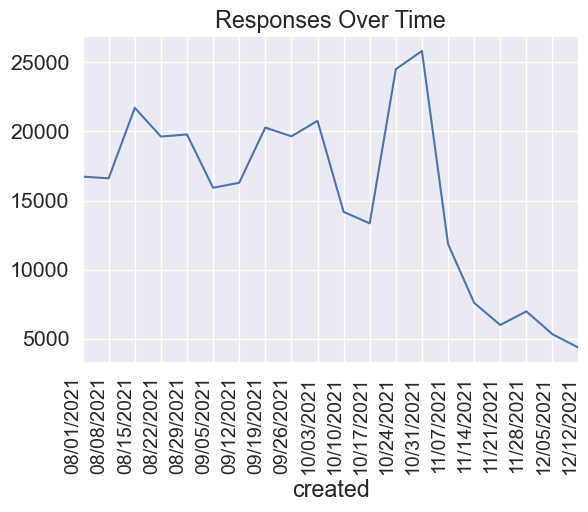

In [174]:
import matplotlib.dates as mdates
weekly_resample = response_features.resample("7D", on="created")

plt.title("Responses Over Time")

weekly_resample.size().plot()
#weekly_resample["user_id"].size().plot()


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.gcf().autofmt_xdate()
plt.xticks(fontsize=14, rotation=90)
plt.show()

### Feature Selection

We have created several features from the response data.

In [212]:
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def run_predictive_model(user_responses, random_var_cols, label_col):
    user_responses = user_responses.dropna()
    # label_col = "precedes_usage_gap"
    # random_var_cols = [
    #     "resp_in_week",
    # ]

    scores = cross_val_score(
        LogisticRegression(max_iter=500), X=user_responses[random_var_cols], y=user_responses[label_col]
    )
    print(
        f"mean: {scores.mean():0.3f}, std: {scores.std():0.3f}"
    )  # print mean and standard deviation


    #get balanced accuracy
    train_df, test_df = train_test_split(user_responses, test_size=0.20, random_state=2)

    model = LogisticRegression(max_iter=500).fit(
    X=train_df[random_var_cols], y=train_df[label_col]
    )
    preds = model.predict(test_df[random_var_cols])
    ground_truth = test_df[label_col]
    print("Balanced accuracy score: ",f"{balanced_accuracy_score(preds, ground_truth):0.3f}")

    #CONFUSION MATRIX
    cm = confusion_matrix(ground_truth, preds)

# plot the confusion matrix using seaborn heatmap
    sns.set(font_scale=1.4)  # adjust font size
    labels = model.classes_
    sns.heatmap(
        cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels
    )

    # add axis labels and title
    plt.xlabel("Predicted as USage Gap")
    plt.ylabel("Actually a Usage Gap")
    plt.title("Confusion Matrix")

    # show the plot
    plt.show()


#get_cross_validation_score(user_weeks=user_weeks)

#from mlxtend.feature_selection import FSSearch
from sklearn.linear_model import LogisticRegression

def feature_selection(responses):
    # Load the dataset
    X = ... # features
    y = ... # target

    # Create a logistic regression model
    model = LogisticRegression()

    # Use FSSearch to select the top 10 features
    fs = FSSearch(model, scoring='accuracy')
    fs.fit(X, y)

    # Print the selected features
    print(fs.best_idx_)


def see_feature_differences(responses, features):
    pass


def show_group_preview(df):
    return df.head(1)

#Group by usage gap
precedes_usage_gap_group = response_features.groupby(["precedes_usage_gap"])

display(precedes_usage_gap_group.apply(show_group_preview))

#Display and compare summary stats between messages that precede usage gaps and non preceding usage gaps
print("Difference in features beween case and non-cases")
display(response_features.groupby(["precedes_usage_gap"]).describe(include="all", datetime_is_numeric=True))

#Todo: Finnish this call to run model
# numeric_features= ["resp_gap",	is_usage_gap	precedes_usage_gap	unique_keys_used	unique_test_questions	unique_lesson_questions]
# run_predictive_model(response_features, random_var_cols=[])

,,,created,updated,user_id,source_id,key,value,correct,resp_gap,total_resp_gap,rolling_resp_count,is_usage_gap,precedes_usage_gap,unique_keys_used,unique_test_questions,unique_lesson_questions
precedes_usage_gap,user_id,id,,,,,,,,,,,,,,,
0.0,19,1064391,2021-11-16 18:03:55,2021-11-16 18:03:55,19,2143637,profile/given-name,7349cce7144bcb471a3e5dae4730d15a2e7e766378fff42ddfccbadaa537f372,0,0.0,0.0,1.0,0,0.0,1,0,0
1.0,35,661757,2021-08-30 09:15:00,2021-08-30 09:15:00,35,1395849,course-spring-2021/step-5-part-1-create/step-5-part-1-lesson-1/go-to-questions#q3,All the above,0,0.0,24.0,10.0,0,1.0,28,0,28


Difference in features beween case and non-cases


created                                                  \
                     count unique  top freq                           mean   
precedes_usage_gap                                                           
0.0                 295843    NaN  NaN  NaN  2021-09-28 23:52:03.279817216   
1.0                   6399    NaN  NaN  NaN  2021-09-27 03:10:34.486951168   

                                                              \
                                    min                  25%   
precedes_usage_gap                                             
0.0                 2021-08-01 01:13:43  2021-08-29 13:46:42   
1.0                 2021-08-01 05:00:56  2021-08-31 05:49:08   

                                                              \
                                    50%                  75%   
precedes_usage_gap                                             
0.0                 2021-09-27 12:42:23  2021-10-27 12:17:13   
1.0                 2021-09-28 05:23:52  2021-10-26 14:51:49   

                                             updated                   \
                                    max  std   count unique  top freq   
precedes_usage_gap                                                      
0.0                 2021-12-18 22:45:27  NaN  295843    NaN  NaN  NaN   
1.0                 2021-12-10 18:15:25  NaN    6399    NaN  NaN  NaN   

                                                                        \
                                             mean                  min   
precedes_usage_gap                                                       
0.0                 2021-09-28 23:52:03.279844608  2021-08-01 01:13:43   
1.0                 2021-09-27 03:10:34.486951168  2021-08-01 05:00:56   

                                                              \
                                    25%                  50%   
precedes_usage_gap                                             
0.0                 2021-08-29 13:46:42  2021-09-27 12:42:23   
1.0                 2021-08-31 05:49:08  2021-09-28 05:23:52   

                                                                    user_id  \
                                    75%                  max  std     count   
precedes_usage_gap                                                            
0.0                 2021-10-27 12:17:13  2021-12-18 22:45:27  NaN  295843.0   
1.0                 2021-10-26 14:51:49  2021-12-10 18:15:25  NaN    6399.0   

                                                                          \
                   unique top freq          mean   min      25%      50%   
precedes_usage_gap                                                         
0.0                   NaN NaN  NaN  41643.150739  19.0  40948.0  43769.0   
1.0                   NaN NaN  NaN  40042.333646  35.0  40331.5  42925.0   

                                                   source_id                  \
                        75%      max           std     count unique top freq   
precedes_usage_gap                                                             
0.0                 46497.0  51436.0   9115.817913  295843.0    NaN NaN  NaN   
1.0                 45616.0  51180.0  10055.137046    6399.0    NaN NaN  NaN   

                                                                             \
                            mean       min        25%        50%        75%   
precedes_usage_gap                                                            
0.0                 1.667485e+06  876772.0  1383797.5  1706716.0  1985096.5   
1.0                 1.661726e+06  877222.0  1410366.5  1713073.0  1950986.5   

                                                 key                      \
                          max            std   count unique          top   
precedes_usage_gap                                                         
0.0                 2232185.0  367223.389962  295843    273  course-menu   
1.0                 2217254.0  330236.112348    63

In [130]:
response_course_2_df.query("key == 'course-menu'").drop_duplicates(subset="value")

,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
434950,2021-08-01 06:04:58,2021-08-01 06:04:58,40127,878026,course-menu,Revise previous content,0
435070,2021-08-01 06:43:42,2021-08-01 06:43:42,40143,878296,course-menu,Course Overview,0
458270,2021-08-03 12:35:15,2021-08-03 12:35:15,38,929741,course-menu,Revise Previous Lesson,0
666001,2021-08-30 16:01:26,2021-08-30 16:01:26,41748,1405231,course-menu,Revise Previous Lesson Step 5 Test,0
929621,2021-10-22 15:48:02,2021-10-22 15:48:02,45293,1927957,course-menu,On the Radio today,0
937233,2021-10-26 11:57:13,2021-10-26 11:57:13,48089,1940933,course-menu,End of,0
937590,2021-10-26 14:11:33,2021-10-26 14:11:33,48575,1941495,course-menu,End of ;,0
949185,2021-10-26 15:54:19,2021-10-26 15:54:19,48243,1959709,course-menu,End of Course-Exam ;,0
967164,2021-10-27 13:46:07,2021-10-27 13:46:07,27659,1986608,course-menu,End of Course-Exam,0


In [80]:
response_features.loc[response_features["user_id"]== 567860]

,,created,updated,user_id,source_id,key,value,correct,day_name,week,resp_gap,usage_gap,unique_keys_used,unique_test_questions,unique_lesson_questions
user_id,id,,,,,,,,,,,,,,


In [75]:
#Test
contains_test = response_course_2_df["key"].str.contains("test")
response_course_2_df.loc[contains_test, "key"].drop_duplicates()

id
438588                                                  yiya-airscience-tests-2021/take-step-1-test#q1
438653                                                  yiya-airscience-tests-2021/take-step-1-test#q2
438699                                                  yiya-airscience-tests-2021/take-step-1-test#q3
438754                                                  yiya-airscience-tests-2021/take-step-1-test#q4
438793                                                  yiya-airscience-tests-2021/take-step-1-test#q5
438930                                                  yiya-airscience-tests-2021/take-step-1-test#q6
439931                                                  yiya-airscience-tests-2021/take-step-2-test#q1
439964                                                  yiya-airscience-tests-2021/take-step-2-test#q2
439992                                                  yiya-airscience-tests-2021/take-step-2-test#q3
440007                                                  yiya-airscienc

Now let's explore the response data. 

/var/folders/91/27xg0jcj2dq9rv01tz61gk9r0000gq/T/ipykernel_15268/1728151149.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  response_course_2_df.groupby(response_course_2_df["created"].dt.week)["user_id"].nunique().plot()


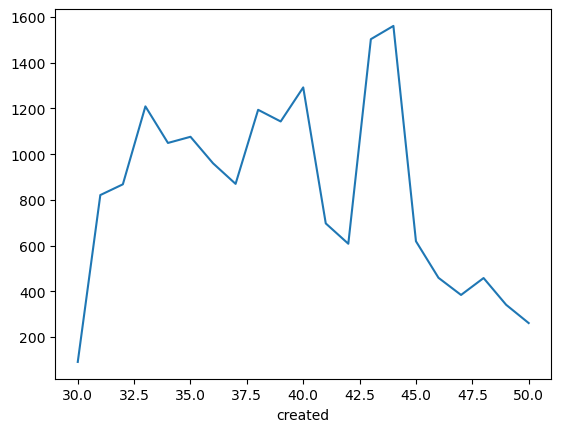

In [34]:
response_course_2_df.groupby(response_course_2_df["created"].dt.week)["user_id"].nunique().plot()
plt.show()

## User Weeks Approach

Expanding REsponse Detials
Now let's expand the time details. 

In [35]:
import numpy as np

def expand_time_info(df):
    df["day_name"] = df["created"].dt.day_name() #add day name
    df["week"] = df["created"].dt.isocalendar().week #add week number
    df["week"] = (df["week"] - df["week"].min() + 1) #scale weeks to start at one
    return df

response_course_2_df = expand_time_info(response_course_2_df.copy())

Now we'll group by user and week and calculate actviity.

In [36]:
#group by user id and week
def calculate_empty_user_weeks(df):
    #expand time details of responses
    df = expand_time_info(df)

    df.info()

    #create a user week for each user for each week
    user_weeks = pd.DataFrame({"user_id" : df["user_id"].unique()})

    max_weeks = df["week"].max()
    user_weeks["week"] = user_weeks.apply(lambda row: np.arange(max_weeks) + 1, axis = 1)

    user_weeks = user_weeks.explode("week")

    return user_weeks.set_index(["user_id", "week"])


def fill_user_weeks(response_course_2_df):
    user_weeks_group = response_course_2_df.groupby(["user_id", "week"]) 

    #get number of responses in each week
    weekly_responses = user_weeks_group.size()

    #Get day used most that week.
    most_active_day = user_weeks_group["day_name"].agg(pd.Series.mode)

    #calculate usage gap
    def set_usage_gaps(x):
        if x == 0:
            return 1
        else: 
            return 0

    usage_gaps =  weekly_responses.apply(set_usage_gaps)

    #calculate intitial weeks
    user_weeks_partial = pd.concat([weekly_responses, most_active_day, usage_gaps], axis=1, keys=["resp_in_week", "most_active_day", "is_usage_gap"])

    #add weeks with no acticity by merging with the empty
    user_weeks_full_empty = calculate_empty_user_weeks(response_course_2_df.copy())
    user_weeks = user_weeks_partial.merge(user_weeks_full_empty, how="outer", left_index=True, right_index=True)

    #Fill resp_in_week if Nan
    user_weeks["resp_in_week"] = user_weeks["resp_in_week"].fillna(0)
    user_weeks

    #Fill resp_in_week if Nan
    user_weeks["most_active_day"] = user_weeks["most_active_day"].fillna("No Day")
    user_weeks


    #calculate usage gap
    user_weeks["is_usage_gap"] = user_weeks["resp_in_week"].apply(set_usage_gaps)
    user_weeks["precedes_usage_gap"] = user_weeks["is_usage_gap"].shift(periods=-1)

    return user_weeks

user_responses = fill_user_weeks(response_course_2_df)
user_responses

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307288 entries, 434312 to 1113386
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   created    307288 non-null  datetime64[ns]
 1   updated    307288 non-null  datetime64[ns]
 2   user_id    307288 non-null  int64         
 3   source_id  307288 non-null  int64         
 4   key        307288 non-null  object        
 5   value      307168 non-null  object        
 6   correct    307288 non-null  int64         
 7   day_name   307288 non-null  object        
 8   week       307288 non-null  UInt32        
dtypes: UInt32(1), datetime64[ns](2), int64(3), object(3)
memory usage: 22.6+ MB


resp_in_week most_active_day  is_usage_gap  precedes_usage_gap
user_id week                                                                
19      1              0.0          No Day             1                 1.0
        2              0.0          No Day             1                 1.0
        3              0.0          No Day             1                 1.0
        4              0.0          No Day             1                 1.0
        5              0.0          No Day             1                 1.0
...                    ...             ...           ...                 ...
51436   17             0.0          No Day             1                 1.0
        18             0.0          No Day             1                 1.0
        19             0.0          No Day             1                 1.0
        20             0.0          No Day             1                 0.0
        21            21.0        Saturday             0                 NaN

[105966 rows x 4 columns]

# Predictions
Now that we have created a user week for each user, we'll can try to predict whether a user_week summary precedes a usage gap.

TODO: Remember to verify that the test and train has both cases.

mean: 0.849, std: 0.003
Balanced accuracy score:  0.749


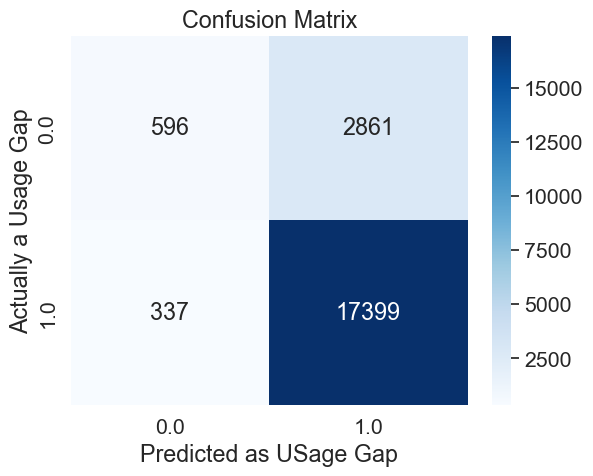

In [37]:
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

def get_cross_validation_score(user_weeks):
    user_weeks = user_weeks.dropna()
    label_col = "precedes_usage_gap"
    random_var_cols = [
        "resp_in_week",
    ]

    scores = cross_val_score(
        LogisticRegression(max_iter=500), X=user_weeks[random_var_cols], y=user_weeks[label_col]
    )
    print(
        f"mean: {scores.mean():0.3f}, std: {scores.std():0.3f}"
    )  # print mean and standard deviation


    #get balanced accuracy
    train_df, test_df = train_test_split(user_weeks, test_size=0.20, random_state=2)

    model = LogisticRegression(max_iter=500).fit(
    X=train_df[random_var_cols], y=train_df[label_col]
    )
    preds = model.predict(test_df[random_var_cols])
    ground_truth = test_df[label_col]
    print("Balanced accuracy score: ",f"{balanced_accuracy_score(preds, ground_truth):0.3f}")

    #CONFUSION MATRIX
    cm = confusion_matrix(ground_truth, preds)

# plot the confusion matrix using seaborn heatmap
    sns.set(font_scale=1.4)  # adjust font size
    labels = model.classes_
    sns.heatmap(
        cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels
    )

    # add axis labels and title
    plt.xlabel("Predicted as USage Gap")
    plt.ylabel("Actually a Usage Gap")
    plt.title("Confusion Matrix")

    # show the plot
    plt.show()


get_cross_validation_score(user_weeks=user_responses)

## Playground

In [61]:
#playground

def custom_func(df):


    #print(df["key"].iloc[0])
    return df

#print(response_course_2_df.groupby("user_id")["created"].diff(periods=1, axis=0).max())
#print(response_course_2_df.shape)

# gropup by multuple columns and apply multiple aggregations
#response_course_2_df.groupby([response_course_2_df["user_id"], response_course_2_df["key"]]).aggregate(["max"])

response_course_2_df.groupby([response_course_2_df["user_id"]]).apply(custom_func)

/var/folders/91/27xg0jcj2dq9rv01tz61gk9r0000gq/T/ipykernel_15268/3831251005.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  response_course_2_df.groupby([response_course_2_df["user_id"]]).apply(custom_func)


,created,updated,user_id,source_id,key,value,correct,day_name,week
id,,,,,,,,,
434312,2021-08-01 01:13:43,2021-08-01 01:13:43,38842,876772,baseline-questions#why-yiya-airscience,Pass exam,0,Sunday,1
434313,2021-08-01 01:13:56,2021-08-01 01:13:56,38842,876773,baseline-questions#why-yiya-airscience/school-enrolment,Yes,0,Sunday,1
434314,2021-08-01 01:15:08,2021-08-01 01:15:08,38842,876775,baseline-questions#why-yiya-airscience/past-experience-with-stem,Yes,0,Sunday,1
434315,2021-08-01 01:15:37,2021-08-01 01:15:37,38842,876776,baseline-questions#why-yiya-airscience/love-for-stem,Definitely,0,Sunday,1
434316,2021-08-01 01:16:01,2021-08-01 01:16:01,38842,876777,baseline-questions#why-yiya-airscience/interest-in-a-job-in-stem,Not sure,0,Sunday,1
...,...,...,...,...,...,...,...,...,...
1113381,2021-12-18 20:32:41,2021-12-18 20:32:41,49371,2232177,yiya-airscience-tests-2021/intro-step-test#q-2,Phone,0,Saturday,21
1113382,2021-12-18 20:32:56,2021-12-18 20:32:56,49371,2232178,yiya-airscience-tests-2021/intro-step-test#q-3,Solids,0,Saturday,21
1113383,2021-12-18 20:33:27,2021-12-18 20:33:27,49371,2232179,yiya-airscience-tests-2021/intro-step-test#q-4,The process of using science and mathematics to simplify life,0,Saturday,21


Where was there significant drop off in course 3?

<Axes: xlabel='created'>

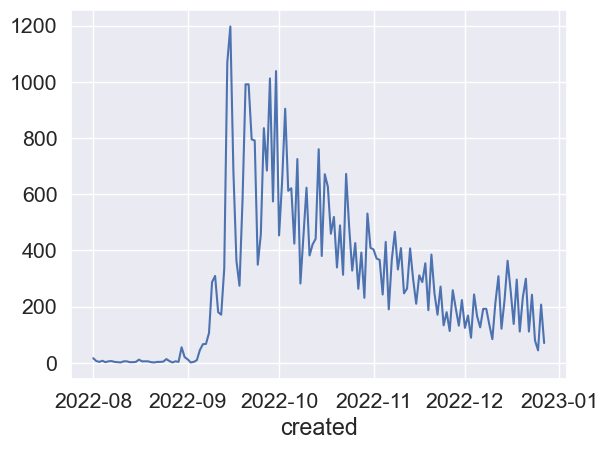

In [59]:
response_df.loc[(response_df["created"] >= "2022-08-01") & ((response_df["created"] <= "2022-12-28"))]\
    .groupby(response_df["created"].dt.date)["user_id"].nunique()\
    .plot()

The model seems to do okay at predicting a usage gap based. Next steps are:
1. gap
2. Identify which groups have the most user gaps. 

In [4]:
# def calculate_empty_user_weeks(df):
#     #expand time details of responses
#     df = expand_time_info(df)

#     df.info()

#     #create a user week for each user for each week
#     user_weeks = pd.DataFrame({"user_id" : df["user_id"].unique()})

#     max_weeks = df["week"].max()
#     user_weeks["week"] = user_weeks.apply(lambda row: np.arange(max_weeks) + 1, axis = 1)

#     user_weeks = user_weeks.explode("week")

#     return user_weeks
    
# # response_course_2_df["created"].dt.day_name()
# # response_course_2_df["created"].dt.isocalendar().week
# #expand_time_info(response_course_2_df.copy())
# calculate_empty_user_weeks(response_course_2_df.copy())

In [ ]:
# def expand_time_info(df):
#     df["day_name"] = df["created"].dt.day_name() #add day name
#     df["week"] = df["created"].dt.isocalendar().week #add week number
#     df["week"] = (df["week"] - df["week"].min() + 1) #scale weeks to start at one
#     return df


In [272]:
# user_weeks = response_course_2_df.groupby(["user_id"]).resample("W", on="created").size()

# def set_usage_gaps(x):
#     if x == 0:
#         return 1
#     else: 
#         return 0



# usage_gaps = user_weeks.apply(set_usage_gaps)

# pd.concat([user_weeks, usage_gaps], keys=["responses", "usage_gaps"], axis=1).describe()

# #response_course_2_df.resample("W", on="created").size()

,responses,usage_gaps
count,30853.000000,30853.000000
mean,9.959745,0.433961
std,14.816784,0.495628
min,0.000000,0.000000
25%,0.000000,0.000000
50%,3.000000,0.000000
75%,15.000000,1.000000
max,184.000000,1.000000


# Identifying Contributing Factors to Completion
This section seeks to run a regression model to identify which features generated from user interactions and input may be strong predictors of a student completing the standard completion criteria. 

These are our steps:
1. Create summary of scripts and content e.g how many questions each script contains. This will help calculate completion. 
2. We will calculate and identify which users reached the standard completion criteria in each course.
3. Then we will summarize each students daily activity according to interactions, e.g percentage of lessons questions completed, types of content consumed, review features used. 
    - Quantify and visualize the correlation for each activity to whether students complete or not
    - Based on correlations, choose the most strongly correlated features to be included in a logistic regression model.
4. We will extract the survey results to identify if and where there is a significant difference between how completed and non-completed users answered the questions. 


In [184]:
content_df[["script", "correct_value"]].drop_duplicates().str.contains()

,script,correct_value
id,,
2099,content/course-spring-2021/step-8-launch/step-8-lesson-3,NaN
4241,content/airscience-2022,NaN
47293,content/airscience-2022a/course/step-5-create/step-5-lesson-1/go-to-questions,All the above
5266,content/sms-categories,None
2403,content/for-registered-radio-wa,NaN
1551,content/course-spring-2021/step-4-plan/step-4-lesson-1,NaN
4843,content/tech-team-static/static-pages/tester-audience,None
29,content/baseline-questions,NaN
16,content/profile/age,NaN


In [181]:
response_df.sample()

,created,updated,user_id,source_id,key,value,correct
id,,,,,,,
1542487,2022-12-18 14:37:38,2022-12-18 14:37:38,57421,3003107,airscience-2022a/course/step-8-launch/step-8-lesson-1/go-to-questions#did-you-listen-to-the-radio-lesson-before-doing-these-questions,Yes,0


In [183]:
content_df.sample()

,created,updated,script,section,version,kind,content,correct_value
id,,,,,,,,
62240,2022-11-18 07:55:52,2022-11-18 07:55:52,content/airscience-2022a/course/step-6-test/step-6-lesson-3/go-to-questions,q1-which-is-true-about-qualitative-and-quantitative-analysis,jAA8jTdu-uzLVT4XAP5P-g,text,That's not it EBONG... Try again.\n1/3: Which is true about Qualitative and quantitative analysis?\n1. Qualitative uses numerical data\n2. Quantitative uses numerical data\n3. All the above,Quantitative uses numerical data


In [179]:
print(task_df["script"].nunique())
print(content_df["script"].nunique())

123
326
